In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from scipy.sparse import hstack

import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
training_df = pd.read_csv("propaganda_train.tsv", sep="\t", header=0)
testing_df = pd.read_csv("propaganda_val.tsv", sep="\t", header=0)

In [ ]:
print("Shape of training data:", training_df.shape)


Shape of training data: (2414, 2)


In [ ]:
training_df.head()

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [ ]:
testing_df.head()

,label,tagged_in_context
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...


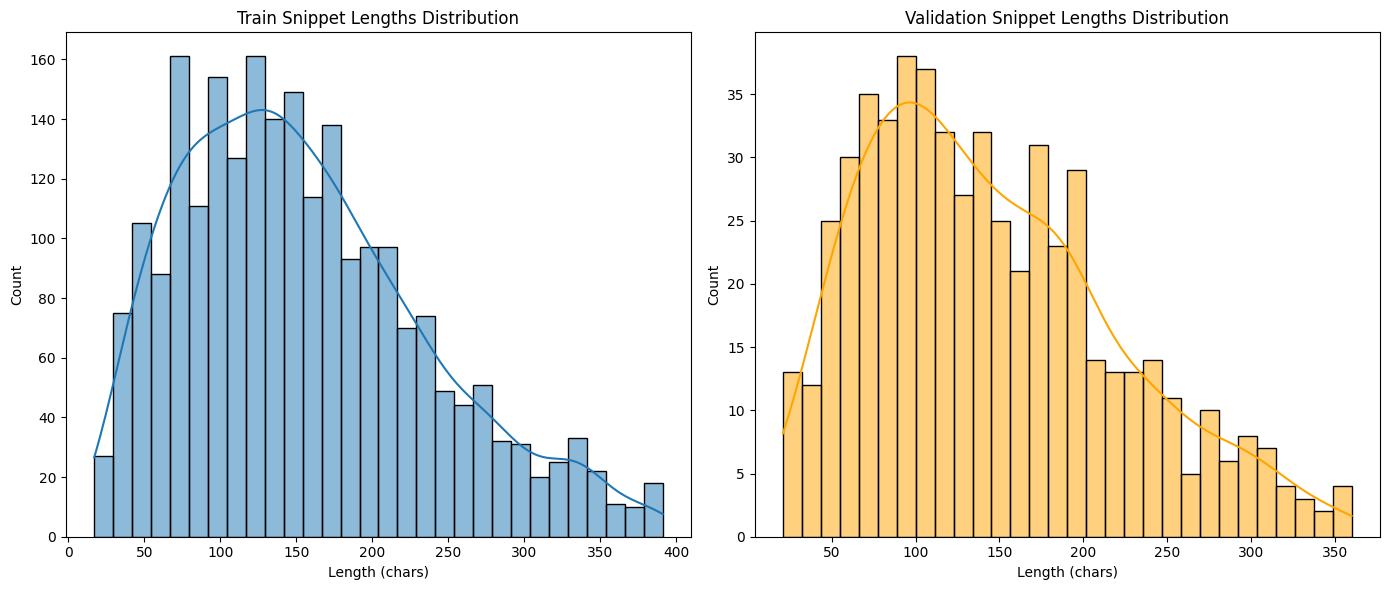

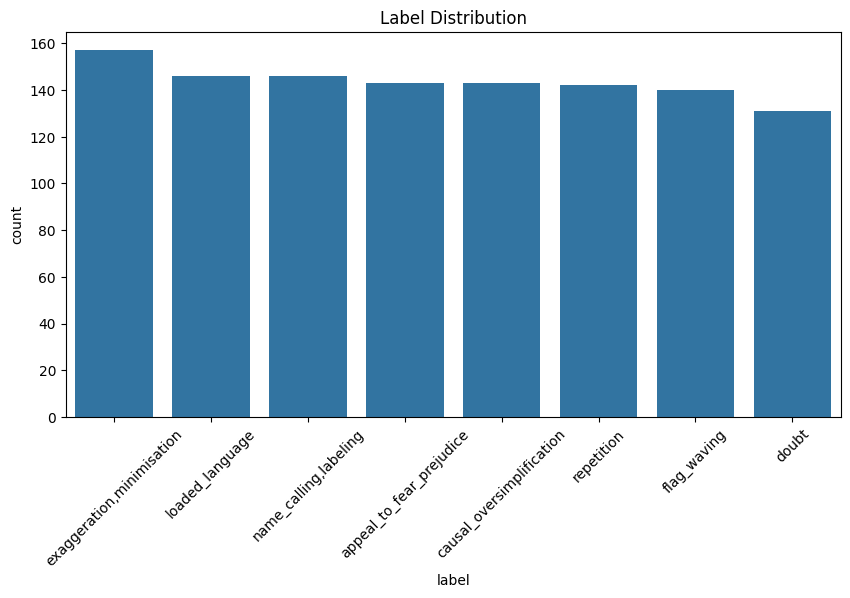

                                   propaganda_snippet  \
2                                      american peopl   
5                                             annihil   
8                                          socal evid   
10                                       hate conduct   
12  point iran ’ s posit itself more aggress milit...   

                                   sentential_context  \
2   obama administr misl american peopl congress b...   
5   hitler annihil 400000 german who were handicap...   
8   note abov point liter everi piec socal evid pu...   
10  hi account suspend violat twitter ’ s rule rel...   
12  a coupl seemingli unrel event past week point ...   

                       label  
2                flag_waving  
5            loaded_language  
8                      doubt  
10     name_calling,labeling  
12  appeal_to_fear_prejudice  


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

# Load Data
training_df = pd.read_csv("propaganda_train.tsv", sep="\t", header=0)
testing_df = pd.read_csv("propaganda_val.tsv", sep="\t", header=0)

# Outlier Visualization
def plot_outlier_hist(x_train, x_val):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    sns.histplot(x_train.astype(str).apply(len), kde=True, ax=axs[0], bins=30)
    axs[0].set_title("Train Snippet Lengths Distribution")
    axs[0].set_xlabel("Length (chars)")

    sns.histplot(x_val.astype(str).apply(len), kde=True, ax=axs[1], bins=30, color='orange')
    axs[1].set_title("Validation Snippet Lengths Distribution")
    axs[1].set_xlabel("Length (chars)")

    plt.tight_layout()
    plt.show()

# IQR-based Outlier Removal
def remove_outliers_iqr(df, column):
    lengths = df[column].astype(str).apply(len)
    Q1 = lengths.quantile(0.25)
    Q3 = lengths.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(lengths >= lower_bound) & (lengths <= upper_bound)]

# Label Distribution Plot
def plot_label_distribution(df):
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
    plt.xticks(rotation=45)
    plt.title("Label Distribution")
    plt.show()

# Preprocessing Function (Offline)
def preprocess_text_task_1_offline(df):
    stemmer = PorterStemmer()
    stop_words = set([
        'the', 'and', 'is', 'in', 'to', 'of', 'that', 'for', 'with', 'on', 'as',
        'are', 'it', 'was', 'at', 'by', 'an', 'be', 'this', 'which', 'or', 'from'
    ])

    def clean_text(text):
        text = text.lower()
        text = re.sub(r'<BOS>|<EOS>', '', text)
        text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
        tokens = word_tokenize(text)
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    def extract_snippet(x):
        try:
            return clean_text(x.split('<BOS>')[1].split('<EOS>')[0])
        except:
            return None

    def extract_sentential_context(x):
        try:
            full_text = re.sub(r'<BOS>|<EOS>', '', x)
            return clean_text(full_text)
        except:
            return None

    df['propaganda_snippet'] = df['tagged_in_context'].apply(extract_snippet)
    df['sentential_context'] = df['tagged_in_context'].apply(extract_sentential_context)

    df = df[
        (df['label'] != 'not_propaganda') &
        (df['propaganda_snippet'].notna()) &
        (df['sentential_context'].notna())
    ]
    return df

# Removing outlier and extract clean data

training_df = remove_outliers_iqr(training_df, 'tagged_in_context')
testing_df = remove_outliers_iqr(testing_df, 'tagged_in_context')

plot_outlier_hist(training_df['tagged_in_context'], testing_df['tagged_in_context'])

train_data_clean = preprocess_text_task_1_offline(training_df)
test_data_clean = preprocess_text_task_1_offline(testing_df)

plot_label_distribution(train_data_clean)

print(train_data_clean[['propaganda_snippet', 'sentential_context', 'label']].head())


In [ ]:
train_data_clean.head()

,label,tagged_in_context,propaganda_snippet,sentential_context
2,flag_waving,The Obama administration misled the <BOS> Amer...,american peopl,obama administr misl american peopl congress b...
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans...",annihil,hitler annihil 400000 german who were handicap...
8,doubt,"As noted above, at this point literally every ...",socal evid,note abov point liter everi piec socal evid pu...
10,"name_calling,labeling",His account was suspended for violating Twitte...,hate conduct,hi account suspend violat twitter ’ s rule rel...
12,appeal_to_fear_prejudice,A couple of seemingly unrelated events this pa...,point iran ’ s posit itself more aggress milit...,a coupl seemingli unrel event past week point ...


# **Task 1 Approach-1 Bag-Of-Words**


================= LOGISTICREGRESSION =================
🔸 Before Tuning:

▶ Training model: LogisticRegression_Base_Propaganda_Classification
⏱ Training time: 0.47 seconds

Accuracy: 0.3902

Classification Report:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.44      0.44      0.44        41
causal_oversimplification       0.30      0.24      0.27        29
                    doubt       0.33      0.36      0.34        36
exaggeration,minimisation       0.32      0.44      0.37        27
              flag_waving       0.59      0.62      0.61        37
          loaded_language       0.33      0.26      0.29        35
    name_calling,labeling       0.38      0.38      0.38        29
               repetition       0.37      0.33      0.35        30

                 accuracy                           0.39       264
                macro avg       0.38      0.38      0.38       264
             weighted avg       0.39      0.39

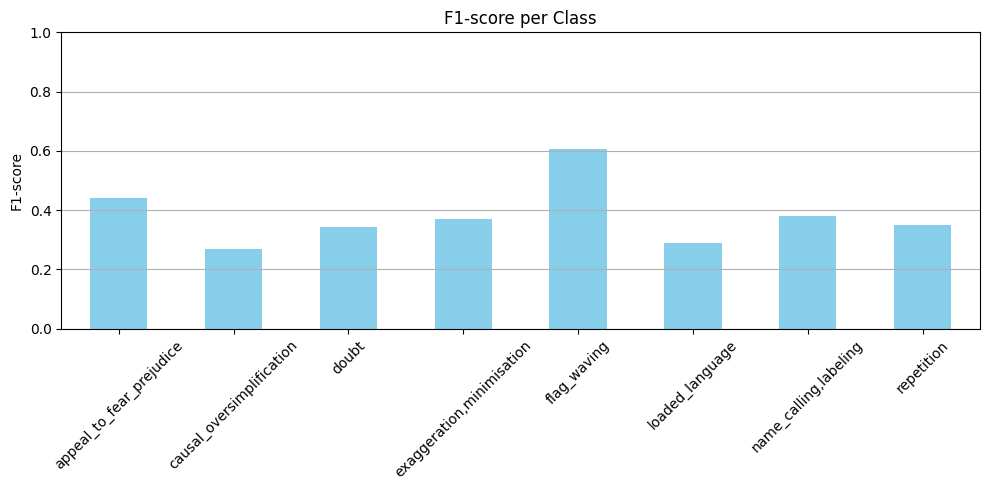

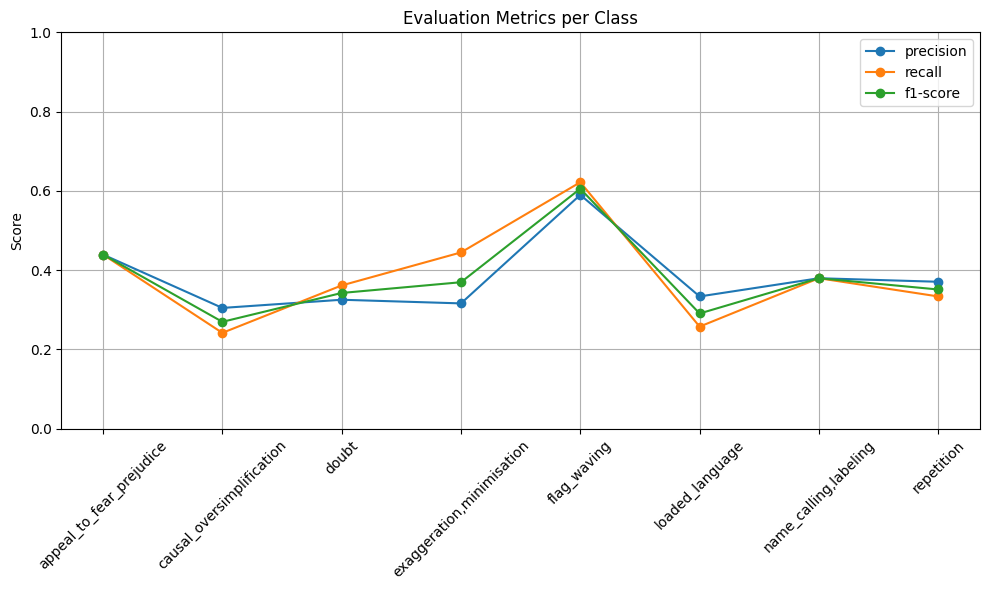


🔸 After Tuning:

Starting grid search...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters found: {'clf__C': 10, 'clf__solver': 'saga', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

▶ Training model: LogisticRegression_Tuned_Propaganda_Classification
⏱ Training time: 0.18 seconds

Accuracy: 0.4015

Classification Report:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.46      0.41      0.44        41
causal_oversimplification       0.29      0.34      0.32        29
                    doubt       0.34      0.44      0.39        36
exaggeration,minimisation       0.31      0.41      0.35        27
              flag_waving       0.60      0.65      0.62        37
          loaded_language       0.37      0.20      0.26        35
    name_calling,labeling       0.34      0.34      0.34        29
               repetition       0.48      0.37      0.42        30

                 accuracy          

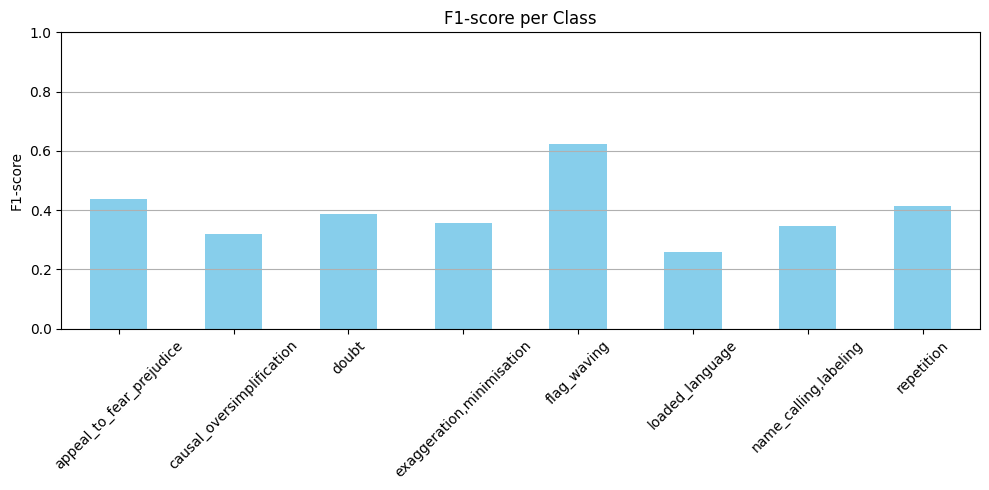

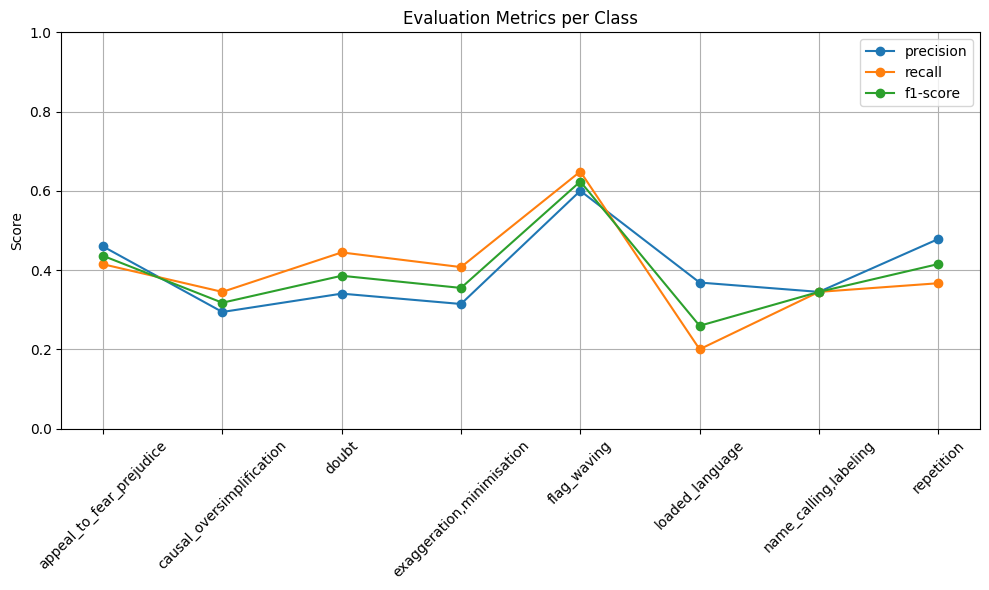


================= MULTINOMIALNB =================
🔸 Before Tuning:

▶ Training model: MultinomialNB_Base_Propaganda_Classification
⏱ Training time: 0.03 seconds

Accuracy: 0.3788

Classification Report:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.49      0.44      0.46        41
causal_oversimplification       0.31      0.41      0.35        29
                    doubt       0.30      0.28      0.29        36
exaggeration,minimisation       0.30      0.59      0.40        27
              flag_waving       0.47      0.73      0.57        37
          loaded_language       0.00      0.00      0.00        35
    name_calling,labeling       0.42      0.28      0.33        29
               repetition       0.43      0.30      0.35        30

                 accuracy                           0.38       264
                macro avg       0.34      0.38      0.35       264
             weighted avg       0.34      0.38      0.35

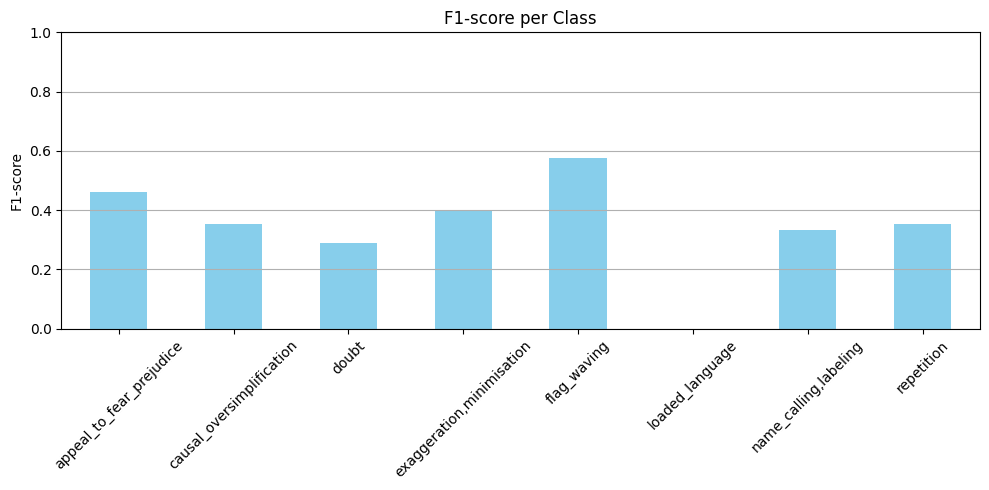

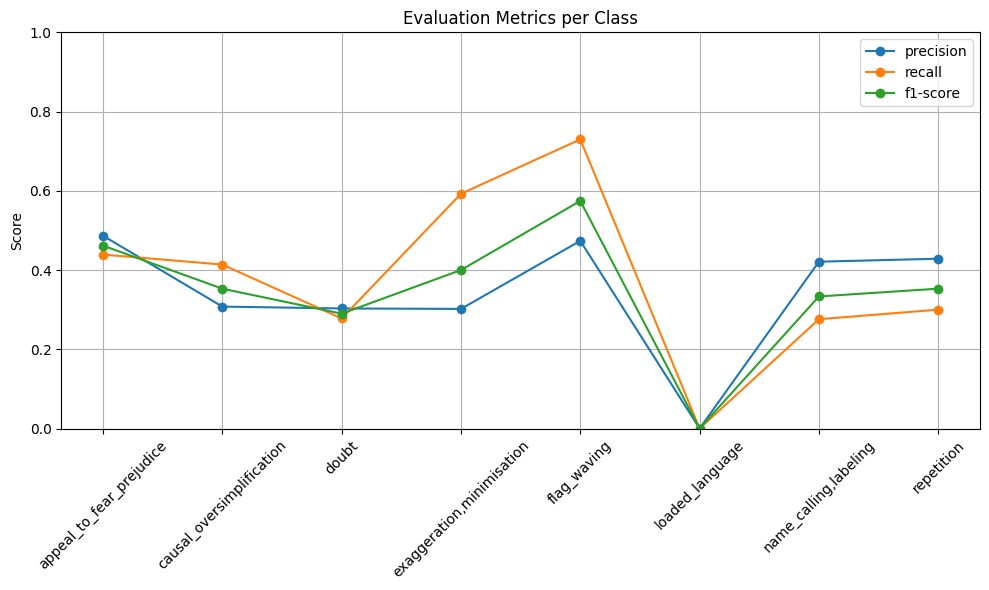


🔸 After Tuning:

Starting grid search...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters found: {'clf__alpha': 1.0, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}

▶ Training model: MultinomialNB_Tuned_Propaganda_Classification
⏱ Training time: 0.03 seconds

Accuracy: 0.3788

Classification Report:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.49      0.44      0.46        41
causal_oversimplification       0.31      0.41      0.35        29
                    doubt       0.30      0.28      0.29        36
exaggeration,minimisation       0.30      0.59      0.40        27
              flag_waving       0.47      0.73      0.57        37
          loaded_language       0.00      0.00      0.00        35
    name_calling,labeling       0.42      0.28      0.33        29
               repetition       0.43      0.30      0.35        30

                 accuracy                           0.38  

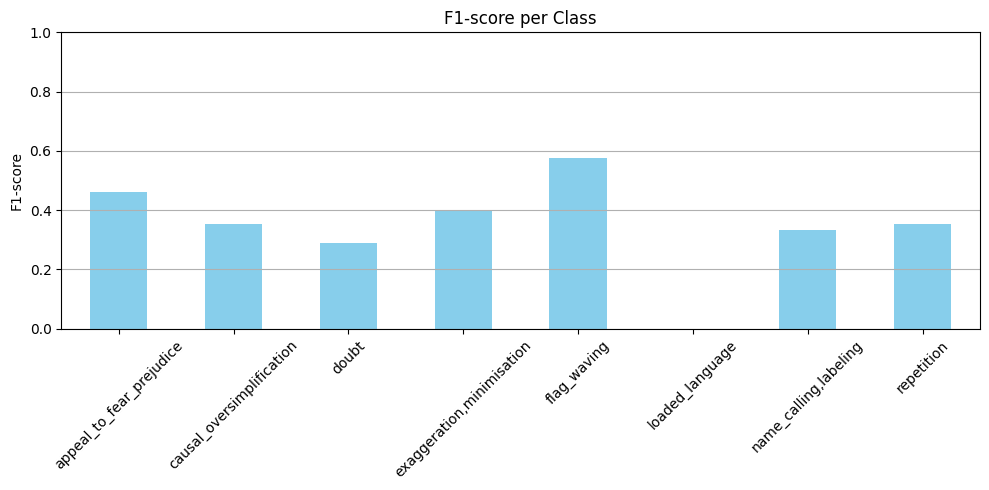

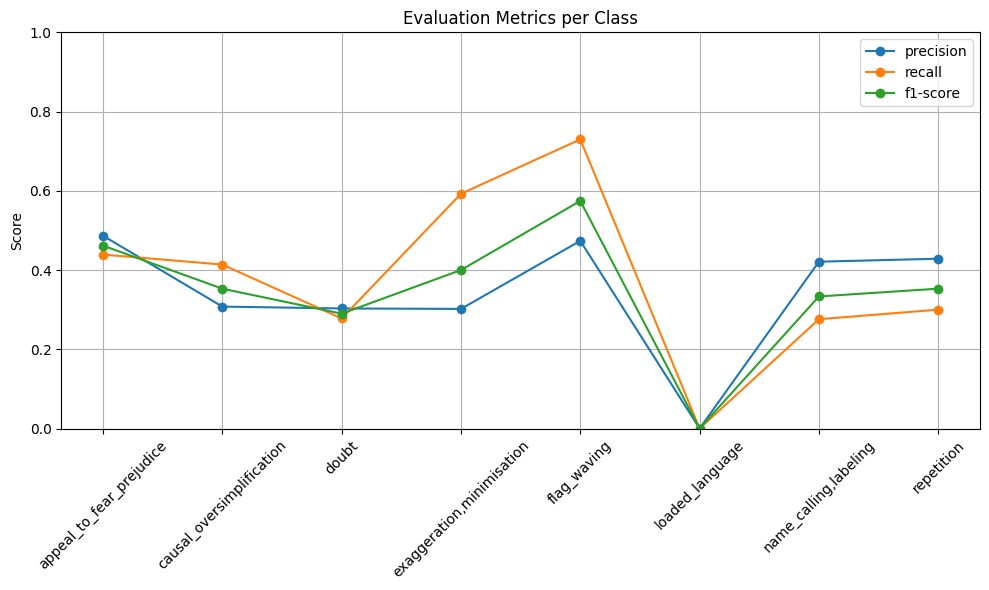


================= SVC =================
🔸 Before Tuning:

▶ Training model: SVC_Base_Propaganda_Classification
⏱ Training time: 1.79 seconds

Accuracy: 0.3750

Classification Report:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.44      0.39      0.42        41
causal_oversimplification       0.41      0.31      0.35        29
                    doubt       0.36      0.25      0.30        36
exaggeration,minimisation       0.26      0.52      0.35        27
              flag_waving       0.71      0.54      0.62        37
          loaded_language       0.28      0.43      0.34        35
    name_calling,labeling       0.25      0.17      0.20        29
               repetition       0.44      0.37      0.40        30

                 accuracy                           0.38       264
                macro avg       0.39      0.37      0.37       264
             weighted avg       0.40      0.38      0.38       264



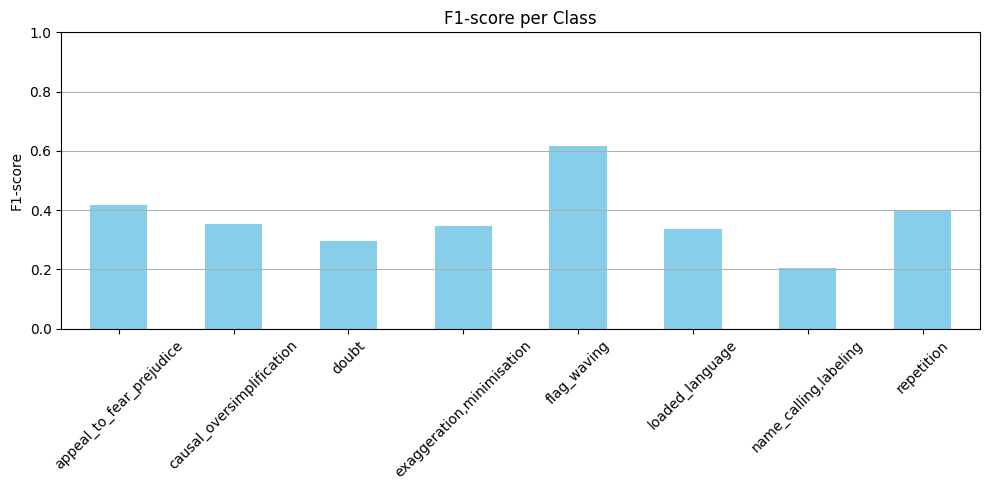

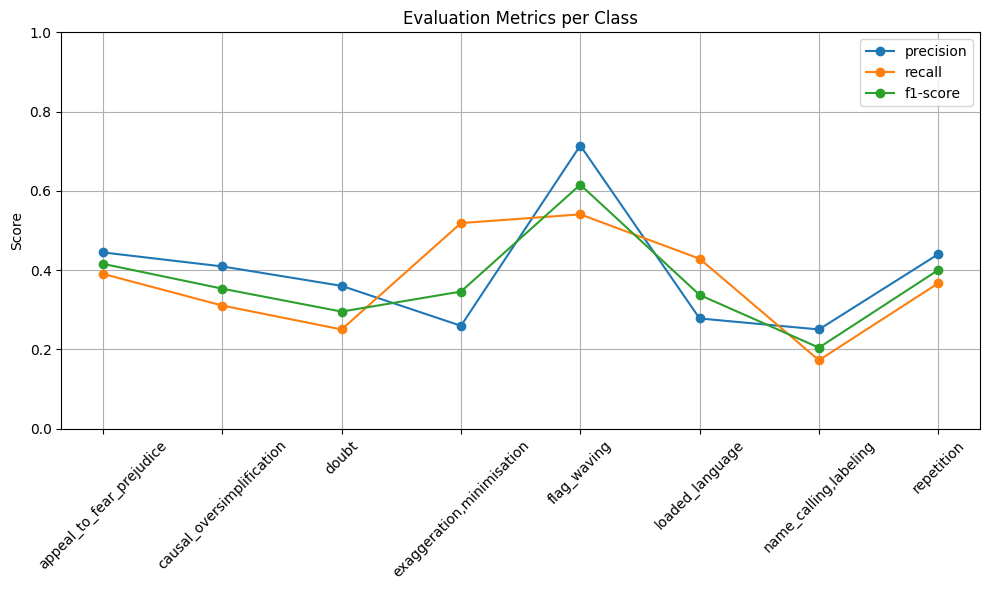


🔸 After Tuning:

Starting grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

▶ Training model: SVC_Tuned_Propaganda_Classification
⏱ Training time: 2.77 seconds

Accuracy: 0.3939

Classification Report:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.47      0.39      0.43        41
causal_oversimplification       0.32      0.38      0.35        29
                    doubt       0.33      0.33      0.33        36
exaggeration,minimisation       0.29      0.52      0.37        27
              flag_waving       0.62      0.65      0.63        37
          loaded_language       0.30      0.20      0.24        35
    name_calling,labeling       0.35      0.31      0.33        29
               repetition       0.48      0.37      0.42        30

                 accuracy   

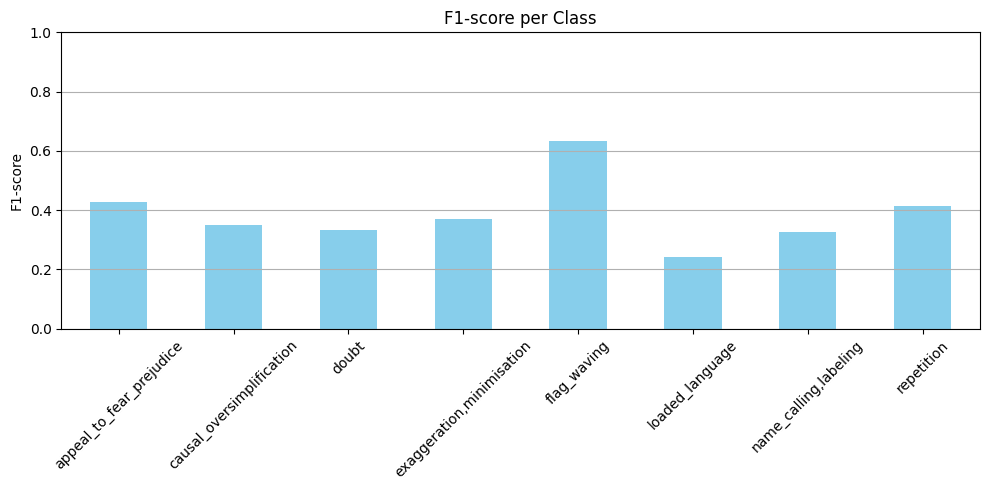

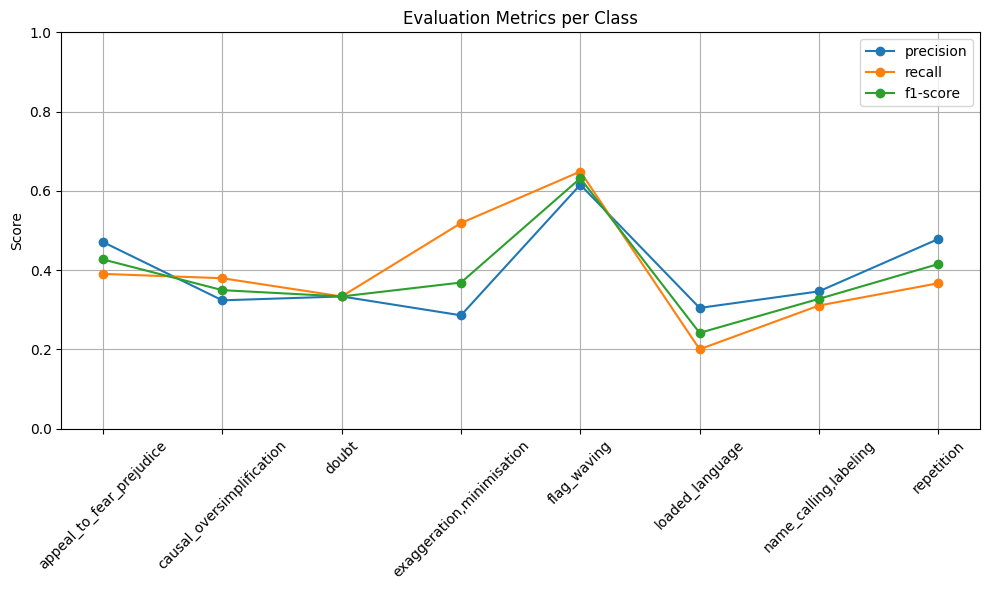


================= LOGISTICREGRESSION =================
Before Tuning:

Training model: LogisticRegression_Base_Propaganda_Classification
Training time: 0.51 seconds

Accuracy: 0.3902

Classification Report:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.44      0.44      0.44        41
causal_oversimplification       0.30      0.24      0.27        29
                    doubt       0.33      0.36      0.34        36
exaggeration,minimisation       0.32      0.44      0.37        27
              flag_waving       0.59      0.62      0.61        37
          loaded_language       0.33      0.26      0.29        35
    name_calling,labeling       0.38      0.38      0.38        29
               repetition       0.37      0.33      0.35        30

                 accuracy                           0.39       264
                macro avg       0.38      0.38      0.38       264
             weighted avg       0.39      0.39      

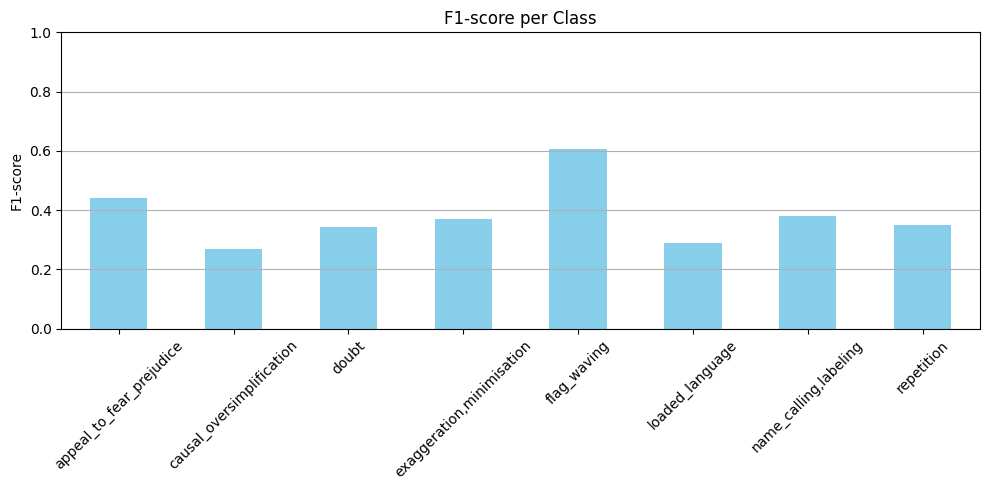

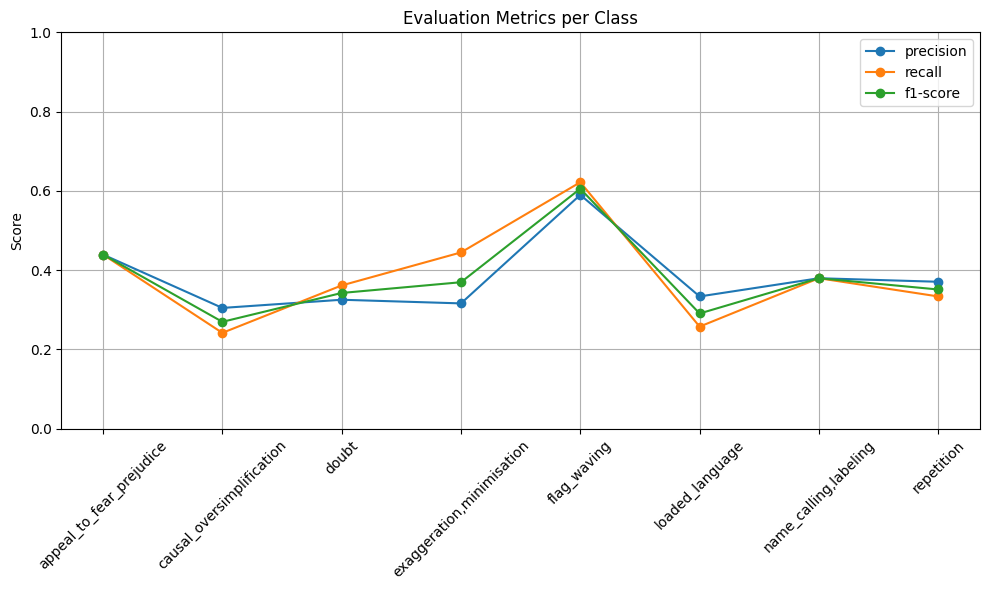


 After Tuning:

Starting grid search...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters found: {'clf__C': 10, 'clf__solver': 'saga', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

Training model: LogisticRegression_Tuned_Propaganda_Classification
Training time: 0.18 seconds

Accuracy: 0.4015

Classification Report:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.46      0.41      0.44        41
causal_oversimplification       0.29      0.34      0.32        29
                    doubt       0.34      0.44      0.39        36
exaggeration,minimisation       0.31      0.41      0.35        27
              flag_waving       0.60      0.65      0.62        37
          loaded_language       0.37      0.20      0.26        35
    name_calling,labeling       0.34      0.34      0.34        29
               repetition       0.48      0.37      0.42        30

                 accuracy               

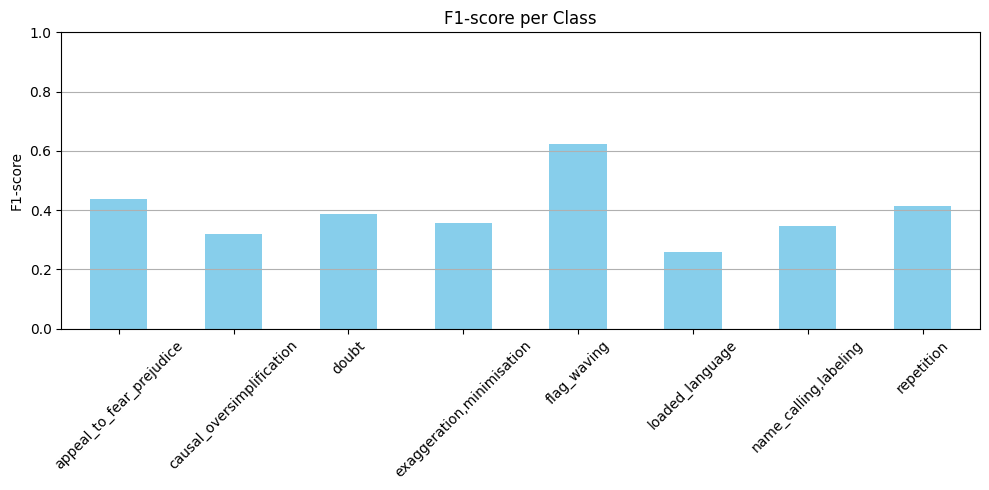

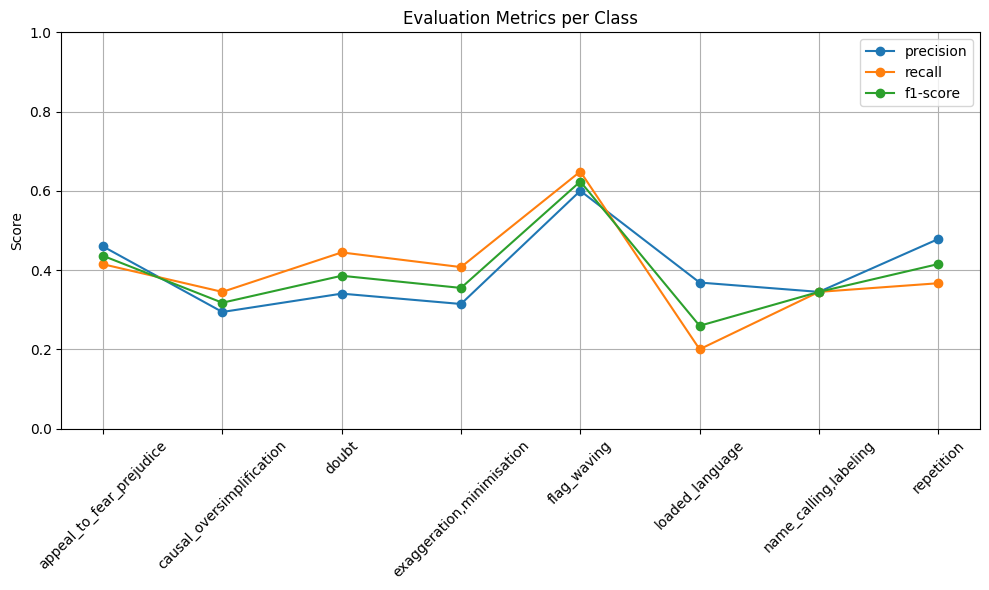


================= MULTINOMIALNB =================
Before Tuning:

Training model: MultinomialNB_Base_Propaganda_Classification
Training time: 0.05 seconds

Accuracy: 0.3788

Classification Report:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.49      0.44      0.46        41
causal_oversimplification       0.31      0.41      0.35        29
                    doubt       0.30      0.28      0.29        36
exaggeration,minimisation       0.30      0.59      0.40        27
              flag_waving       0.47      0.73      0.57        37
          loaded_language       0.00      0.00      0.00        35
    name_calling,labeling       0.42      0.28      0.33        29
               repetition       0.43      0.30      0.35        30

                 accuracy                           0.38       264
                macro avg       0.34      0.38      0.35       264
             weighted avg       0.34      0.38      0.35      

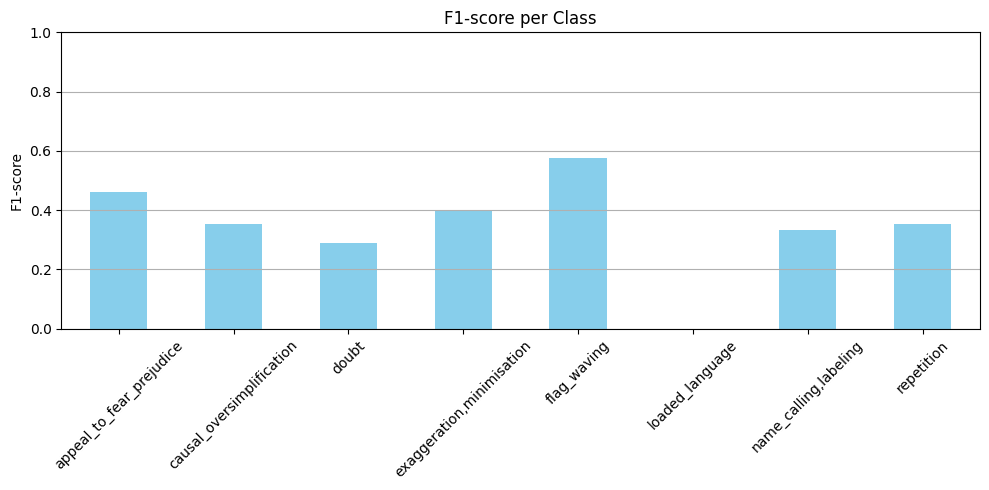

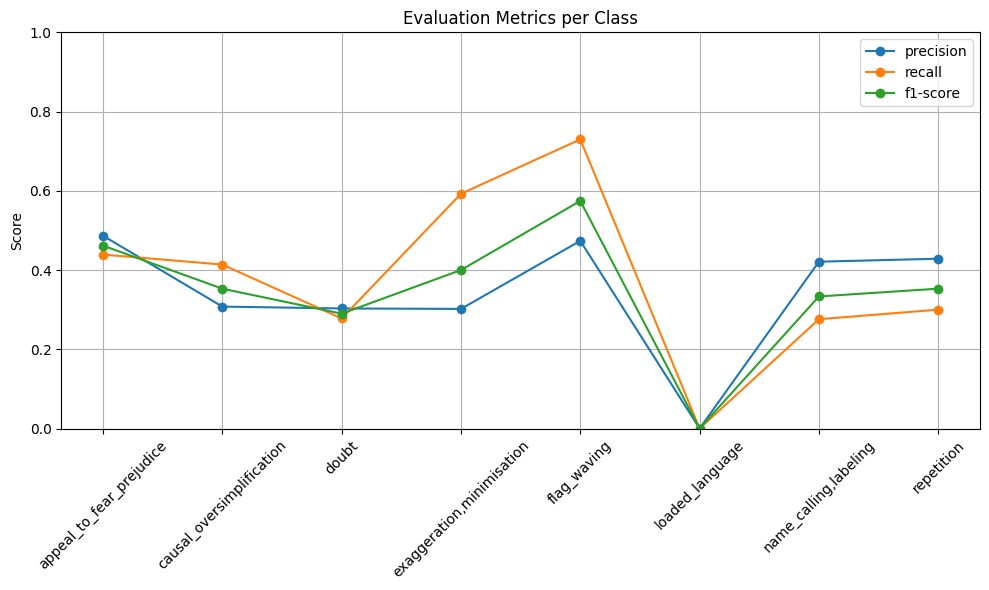


 After Tuning:

Starting grid search...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters found: {'clf__alpha': 1.0, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}

Training model: MultinomialNB_Tuned_Propaganda_Classification
Training time: 0.03 seconds

Accuracy: 0.3788

Classification Report:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.49      0.44      0.46        41
causal_oversimplification       0.31      0.41      0.35        29
                    doubt       0.30      0.28      0.29        36
exaggeration,minimisation       0.30      0.59      0.40        27
              flag_waving       0.47      0.73      0.57        37
          loaded_language       0.00      0.00      0.00        35
    name_calling,labeling       0.42      0.28      0.33        29
               repetition       0.43      0.30      0.35        30

                 accuracy                           0.38       

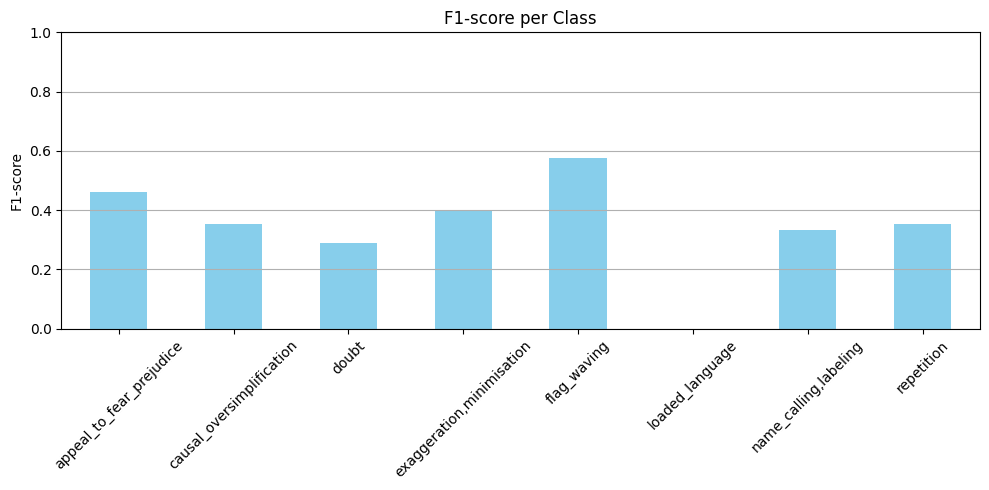

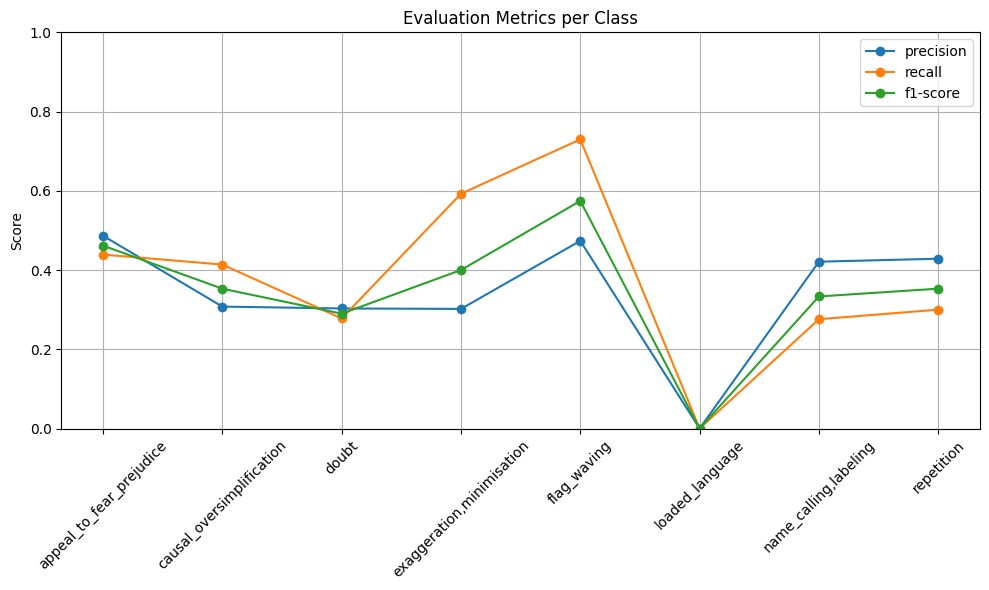


================= SVC =================
Before Tuning:

Training model: SVC_Base_Propaganda_Classification
Training time: 2.13 seconds

Accuracy: 0.3750

Classification Report:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.44      0.39      0.42        41
causal_oversimplification       0.41      0.31      0.35        29
                    doubt       0.36      0.25      0.30        36
exaggeration,minimisation       0.26      0.52      0.35        27
              flag_waving       0.71      0.54      0.62        37
          loaded_language       0.28      0.43      0.34        35
    name_calling,labeling       0.25      0.17      0.20        29
               repetition       0.44      0.37      0.40        30

                 accuracy                           0.38       264
                macro avg       0.39      0.37      0.37       264
             weighted avg       0.40      0.38      0.38       264



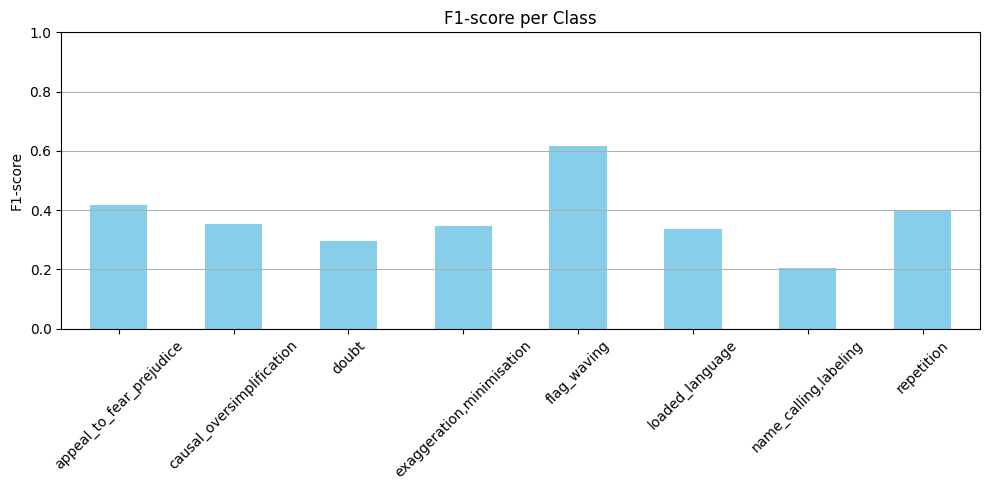

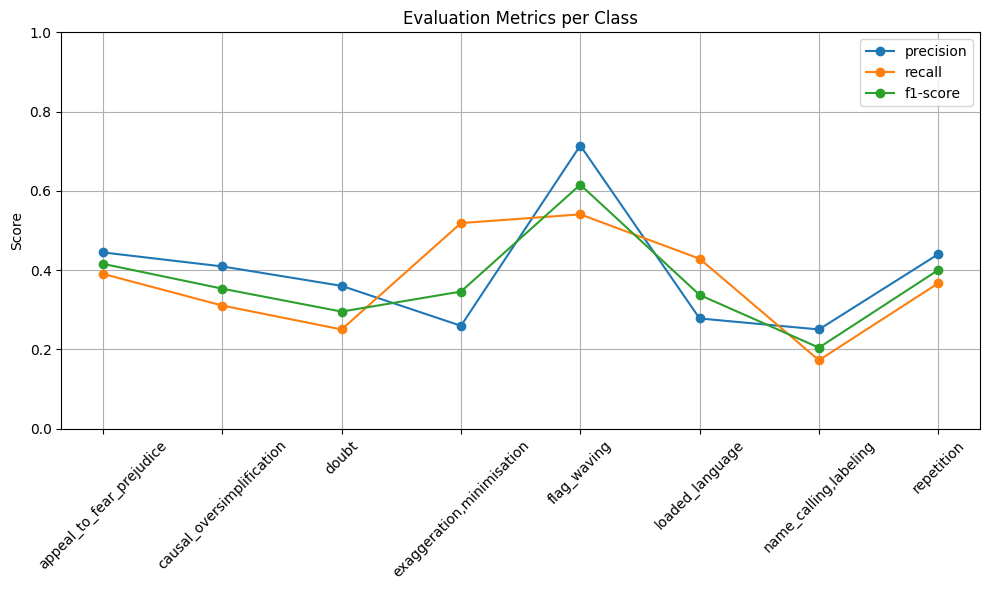


 After Tuning:

Starting grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

Training model: SVC_Tuned_Propaganda_Classification
Training time: 2.37 seconds

Accuracy: 0.3939

Classification Report:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.47      0.39      0.43        41
causal_oversimplification       0.32      0.38      0.35        29
                    doubt       0.33      0.33      0.33        36
exaggeration,minimisation       0.29      0.52      0.37        27
              flag_waving       0.62      0.65      0.63        37
          loaded_language       0.30      0.20      0.24        35
    name_calling,labeling       0.35      0.31      0.33        29
               repetition       0.48      0.37      0.42        30

                 accuracy        

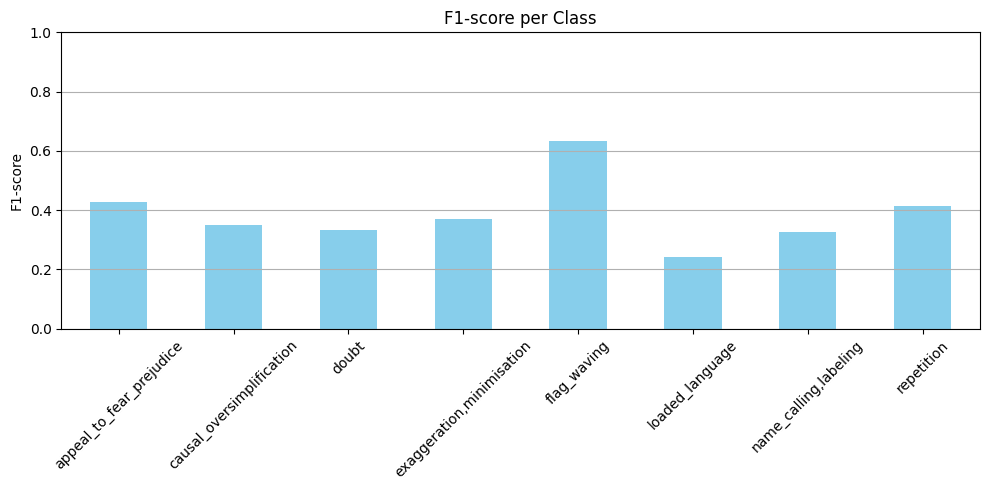

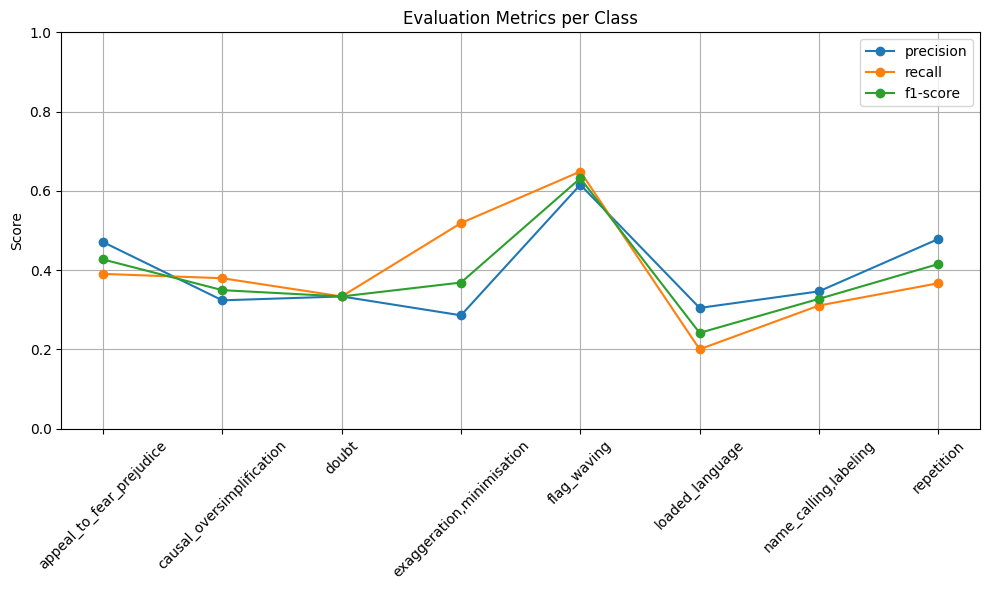

In [ ]:
# Evaluation plot with optional normalization
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
# Evaluation plot with optional normalization
def plot_evaluation(y_true, y_pred):
    from sklearn.metrics import classification_report
    import pandas as pd
    import matplotlib.pyplot as plt

    # Get classification report as a DataFrame
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])

    # Bar plot of F1-scores
    plt.figure(figsize=(10, 5))
    report_df['f1-score'].plot(kind='bar', color='skyblue')
    plt.title("F1-score per Class")
    plt.ylabel("F1-score")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Line plot of Precision, Recall, F1
    plt.figure(figsize=(10, 6))
    for metric in ['precision', 'recall', 'f1-score']:
        plt.plot(report_df.index, report_df[metric], marker='o', label=metric)
    plt.title("Evaluation Metrics per Class")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Model training and evaluation
def train_and_evaluate(model, X_train, y_train, X_val, y_val, name=""):
    print(f"\n▶ Training model: {name}")
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    print(f"⏱ Training time: {end - start:.2f} seconds")

    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)

    print(f"\nAccuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_val, preds))
    plot_evaluation(y_val, preds)

# Hyperparameter tuning
def tune_model(model, param_grid, X_train, y_train):
    print("\nStarting grid search...")
    grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print("Best parameters found:", grid.best_params_)
    return grid.best_estimator_

# Comparing models
def compare_models(X_train, y_train, X_val, y_val, pipelines, param_grids, task=""):
    for name, pipe in pipelines.items():
        print(f"\n================= {name.upper()} =================")
        print("🔸 Before Tuning:")
        train_and_evaluate(pipe, X_train, y_train, X_val, y_val, name + "_Base_" + task)

        print("\n🔸 After Tuning:")
        tuned_model = tune_model(pipe, param_grids[name], X_train, y_train)
        train_and_evaluate(tuned_model, X_train, y_train, X_val, y_val, name + "_Tuned_" + task)


# Create feature sets
X_train = train_data_clean['propaganda_snippet'] + ' ' + train_data_clean['sentential_context']
y_train = train_data_clean['label']
X_val = test_data_clean['propaganda_snippet'] + ' ' + test_data_clean['sentential_context']
y_val = test_data_clean['label']

# Pipelines map
pipelines = {
    'LogisticRegression': Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'MultinomialNB': Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
    ]),
    'SVC': Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(probability=True))
    ])
}

# Updated and simplified parameter grid
param_grids = {
    'LogisticRegression': {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': [True, False],
        'clf__C': [0.1, 1, 10],
        'clf__solver': ['liblinear', 'saga']
    },
    'MultinomialNB': {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': [True, False],
        'clf__alpha': [0.1, 1.0, 10.0]
    },
    'SVC': {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': [True, False],
        'clf__C': [1, 10],
        'clf__kernel': ['linear', 'rbf'],
        'clf__gamma': ['scale']
    }
}

# Run the comparison
compare_models(X_train, y_train, X_val, y_val, pipelines, param_grids, task="Propaganda_Classification")


# Model training and evaluation
def train_and_evaluate(model, X_train, y_train, X_val, y_val, name=""):
    print(f"\nTraining model: {name}")
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    print(f"Training time: {end - start:.2f} seconds")

    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)

    print(f"\nAccuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_val, preds))
    plot_evaluation(y_val, preds)

# Hyperparameter tuning
def tune_model(model, param_grid, X_train, y_train):
    print("\nStarting grid search...")
    grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print("Best parameters found:", grid.best_params_)
    return grid.best_estimator_

# Comparing models
def compare_models(X_train, y_train, X_val, y_val, pipelines, param_grids, task=""):
    for name, pipe in pipelines.items():
        print(f"\n================= {name.upper()} =================")
        print("Before Tuning:")
        train_and_evaluate(pipe, X_train, y_train, X_val, y_val, name + "_Base_" + task)

        print("\n After Tuning:")
        tuned_model = tune_model(pipe, param_grids[name], X_train, y_train)
        train_and_evaluate(tuned_model, X_train, y_train, X_val, y_val, name + "_Tuned_" + task)


# Create feature sets
X_train = train_data_clean['propaganda_snippet'] + ' ' + train_data_clean['sentential_context']
y_train = train_data_clean['label']
X_val = test_data_clean['propaganda_snippet'] + ' ' + test_data_clean['sentential_context']
y_val = test_data_clean['label']

# Pipelines map
pipelines = {
    'LogisticRegression': Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'MultinomialNB': Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
    ]),
    'SVC': Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(probability=True))
    ])
}

# Updated and simplified parameter grid
param_grids = {
    'LogisticRegression': {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': [True, False],
        'clf__C': [0.1, 1, 10],
        'clf__solver': ['liblinear', 'saga']
    },
    'MultinomialNB': {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': [True, False],
        'clf__alpha': [0.1, 1.0, 10.0]
    },
    'SVC': {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': [True, False],
        'clf__C': [1, 10],
        'clf__kernel': ['linear', 'rbf'],
        'clf__gamma': ['scale']
    }
}

# Run the comparison
compare_models(X_train, y_train, X_val, y_val, pipelines, param_grids, task="Propaganda_Classification")


# **Task 1 Approach-2 Word2Vec**

In [ ]:
#  Fix for gensim + scipy compatibility
!pip install  gensim==4.3.1


In [ ]:
import gensim.downloader as api
model_w2v = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded



================= LOGISTICREGRESSION =================
 Before Tuning:

 Training model: LogisticRegression_Base_Word2Vec

 Accuracy: 0.3485

 Classification Report:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.37      0.39      0.38        41
causal_oversimplification       0.24      0.28      0.25        29
                    doubt       0.40      0.33      0.36        36
exaggeration,minimisation       0.21      0.30      0.25        27
              flag_waving       0.53      0.65      0.59        37
          loaded_language       0.35      0.17      0.23        35
    name_calling,labeling       0.39      0.48      0.43        29
               repetition       0.19      0.13      0.16        30

                 accuracy                           0.35       264
                macro avg       0.34      0.34      0.33       264
             weighted avg       0.35      0.35      0.34       264



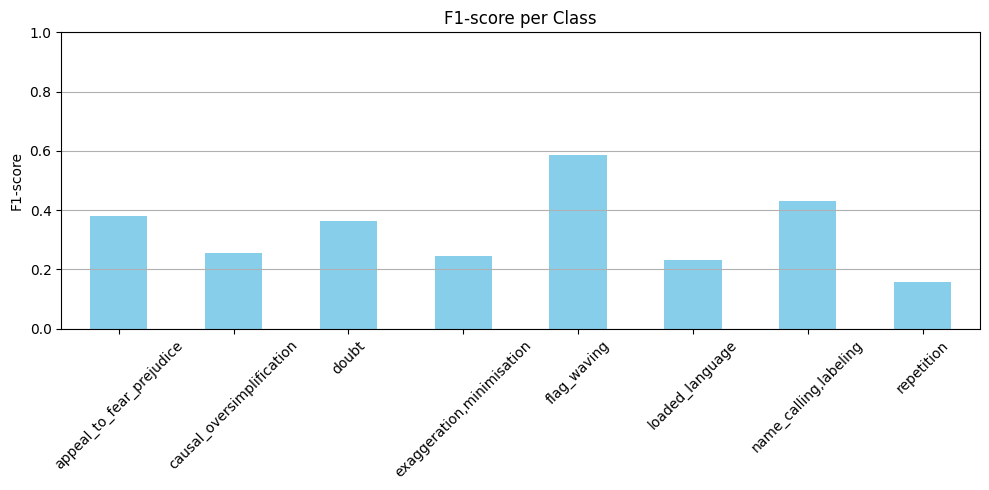

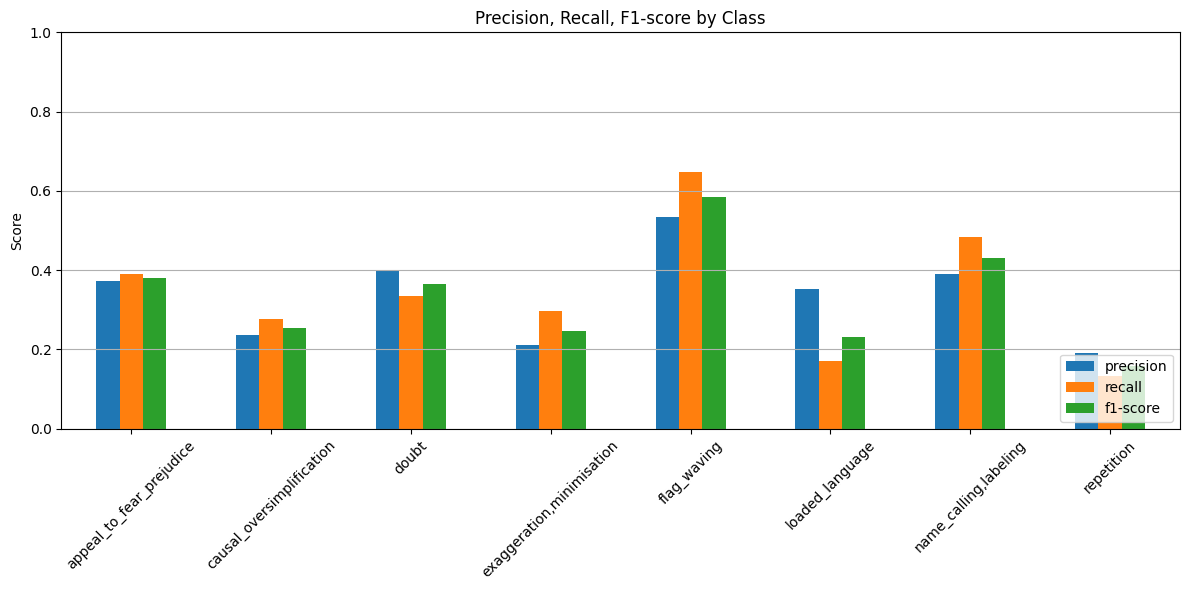


 After Tuning:

Tuning hyperparameters...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
 Best parameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'saga'}

 Training model: LogisticRegression_Tuned_Word2Vec

 Accuracy: 0.3333

 Classification Report:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.40      0.34      0.37        41
causal_oversimplification       0.23      0.24      0.24        29
                    doubt       0.37      0.31      0.33        36
exaggeration,minimisation       0.24      0.30      0.26        27
              flag_waving       0.50      0.65      0.56        37
          loaded_language       0.27      0.17      0.21        35
    name_calling,labeling       0.31      0.55      0.40        29
               repetition       0.14      0.07      0.09        30

                 accuracy                           0.33       264
                macro avg       0.31      0.33  

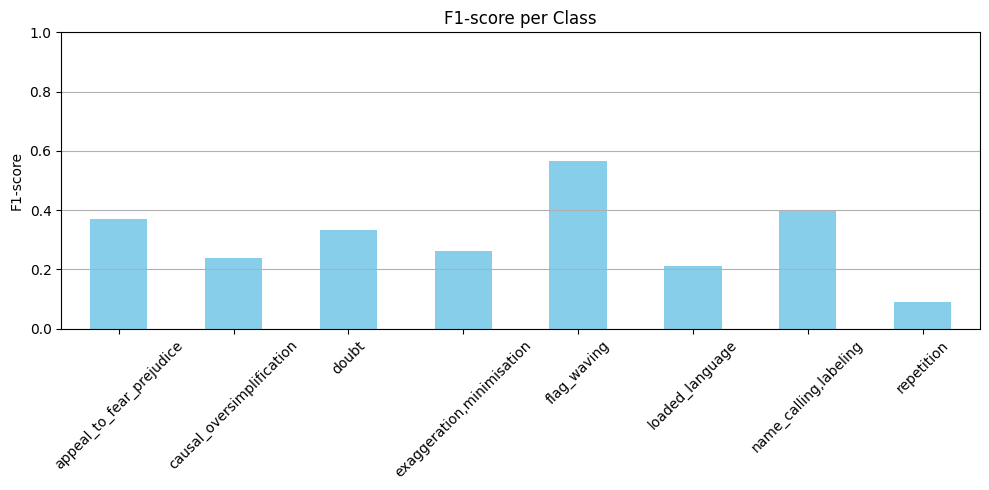

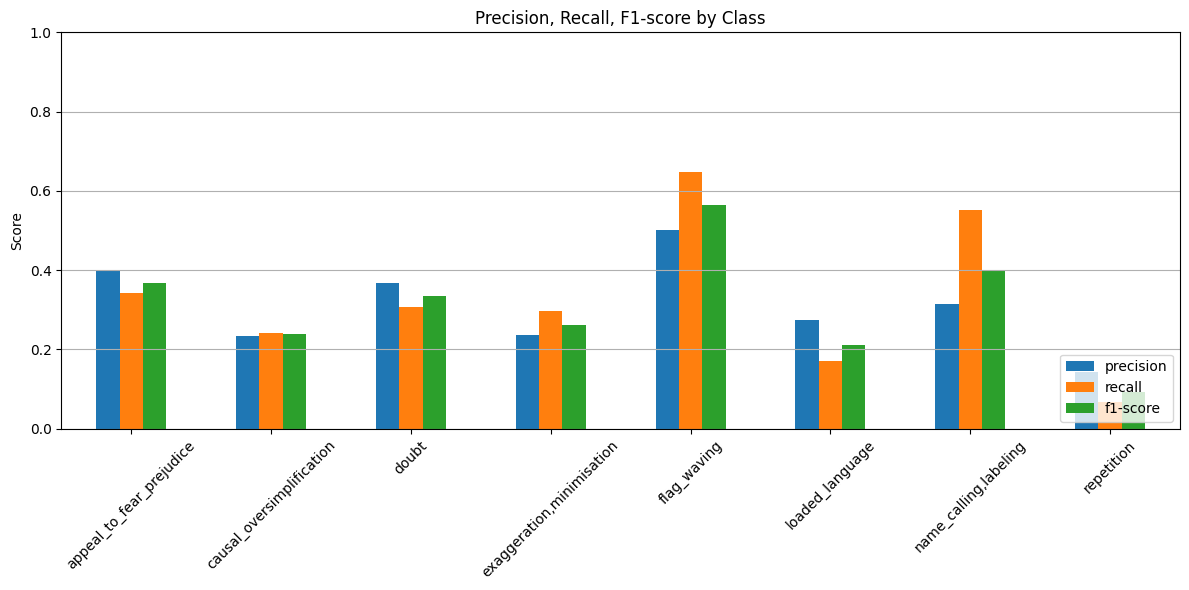


================= SVC =================
 Before Tuning:

 Training model: SVC_Base_Word2Vec

 Accuracy: 0.3523

 Classification Report:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.42      0.37      0.39        41
causal_oversimplification       0.20      0.24      0.22        29
                    doubt       0.36      0.36      0.36        36
exaggeration,minimisation       0.27      0.33      0.30        27
              flag_waving       0.59      0.65      0.62        37
          loaded_language       0.35      0.20      0.25        35
    name_calling,labeling       0.26      0.48      0.34        29
               repetition       0.40      0.13      0.20        30

                 accuracy                           0.35       264
                macro avg       0.36      0.35      0.34       264
             weighted avg       0.37      0.35      0.34       264



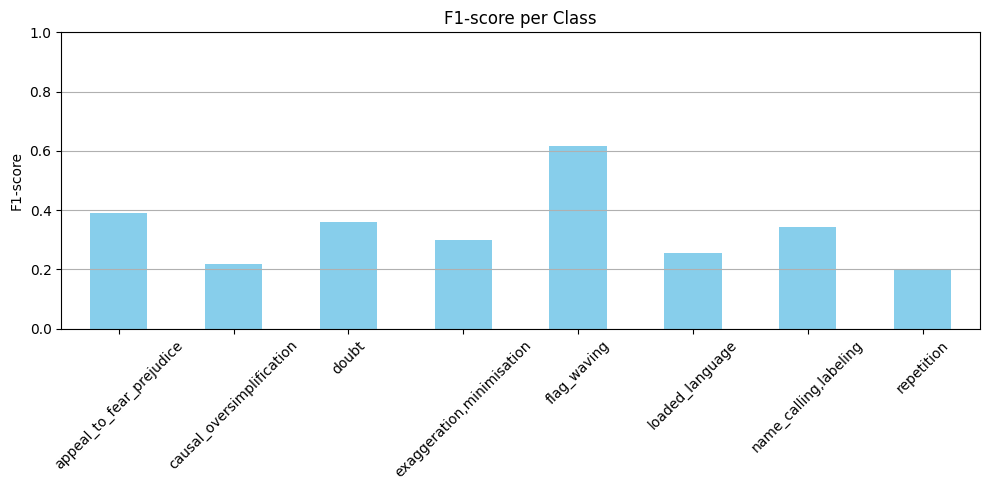

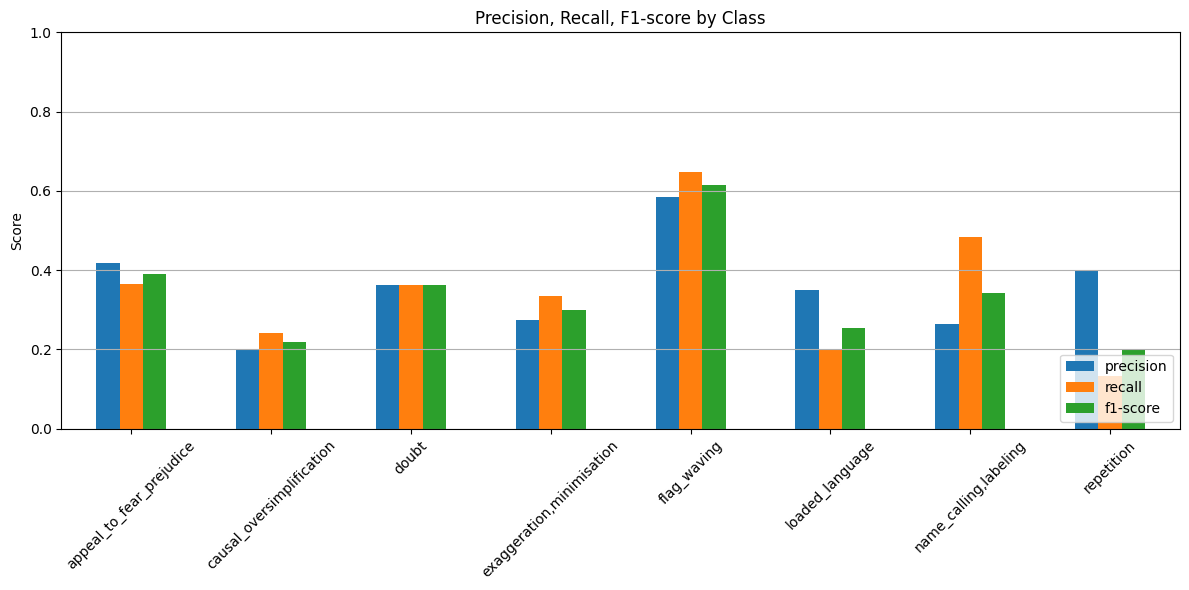


 After Tuning:

Tuning hyperparameters...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
 Best parameters: {'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}

 Training model: SVC_Tuned_Word2Vec

 Accuracy: 0.3144

 Classification Report:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.36      0.37      0.36        41
causal_oversimplification       0.21      0.24      0.22        29
                    doubt       0.36      0.36      0.36        36
exaggeration,minimisation       0.24      0.30      0.26        27
              flag_waving       0.57      0.62      0.60        37
          loaded_language       0.21      0.17      0.19        35
    name_calling,labeling       0.24      0.31      0.27        29
               repetition       0.17      0.07      0.10        30

                 accuracy                           0.31       264
                macro avg       0.29      0.30      0.29       26

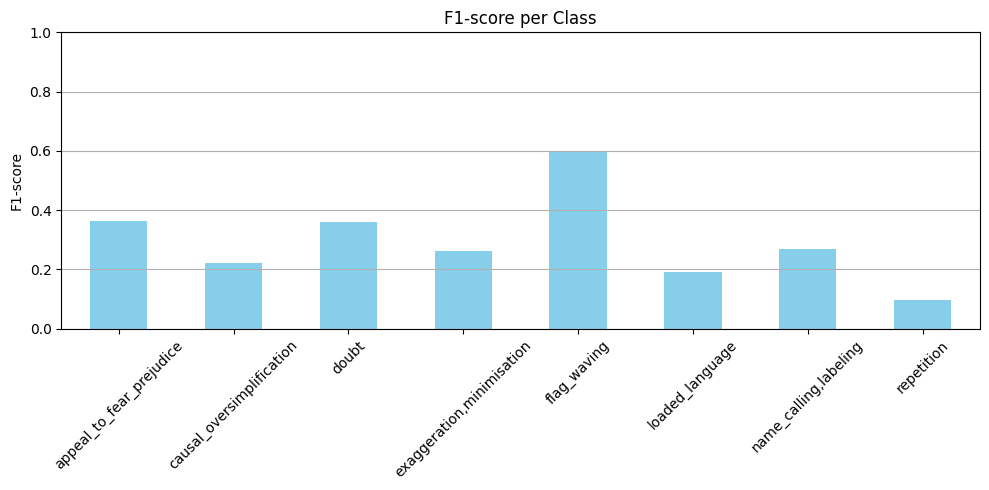

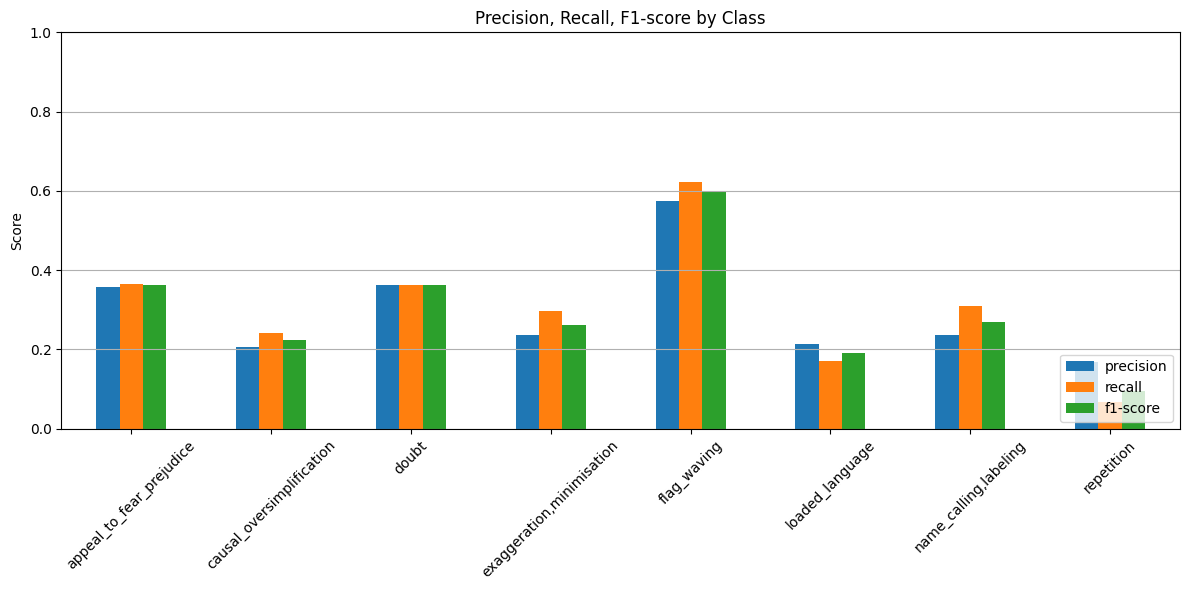

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from gensim.models import KeyedVectors  # or Word2Vec if trained from scratch



# Convert sentences to averaged word vectors
def document_vector(doc):
    doc = [word for word in doc.split() if word in model_w2v.key_to_index]
    return np.mean(model_w2v[doc], axis=0) if doc else np.zeros(model_w2v.vector_size)

# Apply vectorization
train_data_clean['doc_vector'] = (train_data_clean['propaganda_snippet'] + ' ' + train_data_clean['sentential_context']).apply(document_vector)
test_data_clean['doc_vector'] = (test_data_clean['propaganda_snippet'] + ' ' + test_data_clean['sentential_context']).apply(document_vector)

X_train_vec = np.array(list(train_data_clean['doc_vector']))
X_val_vec = np.array(list(test_data_clean['doc_vector']))
y_train = train_data_clean['label'].values
y_val = test_data_clean['label'].values

# Plot evaluation with bar graphs
def plot_evaluation(y_true, y_pred):
    from sklearn.metrics import classification_report

    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df = df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

    # F1-score per class
    plt.figure(figsize=(10, 5))
    df['f1-score'].plot(kind='bar', color='skyblue')
    plt.title("F1-score per Class")
    plt.ylabel("F1-score")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Grouped bar chart for precision, recall, f1
    df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
    plt.title("Precision, Recall, F1-score by Class")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Training and evaluation function
def train_and_evaluate(model, X_train, y_train, X_val, y_val, name=""):
    print(f"\n Training model: {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    acc = accuracy_score(y_val, preds)
    print(f"\n Accuracy: {acc:.4f}")
    print("\n Classification Report:\n", classification_report(y_val, preds))
    plot_evaluation(y_val, preds)

#Grid search tuning
def tune_model(model, param_grid, X_train, y_train):
    print("\nTuning hyperparameters...")
    grid = GridSearchCV(model, param_grid, cv=3, verbose=1, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(" Best parameters:", grid.best_params_)
    return grid.best_estimator_

#  Compare models
def compare_models(X_train, y_train, X_val, y_val, pipelines, param_grids, task=""):
    for name, pipeline in pipelines.items():
        print(f"\n================= {name.upper()} =================")
        print(" Before Tuning:")
        train_and_evaluate(pipeline, X_train, y_train, X_val, y_val, name + "_Base_" + task)

        print("\n After Tuning:")
        tuned_model = tune_model(pipeline, param_grids[name], X_train, y_train)
        train_and_evaluate(tuned_model, X_train, y_train, X_val, y_val, name + "_Tuned_" + task)

# Define pipelines
pipelines = {
    'LogisticRegression': Pipeline([
        ('clf', LogisticRegression(random_state=0, max_iter=1000))
    ]),
    'SVC': Pipeline([
        ('clf', SVC(probability=True))
    ])
}

#  Define parameter grids
param_grids = {
    'LogisticRegression': {
        'clf__C': [0.001, 0.01, 0.1, 1, 10],
        'clf__penalty': ['l1', 'l2'],
        'clf__solver': ['liblinear', 'saga']  # support both L1 and L2
    },
    'SVC': {
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf'],
        'clf__gamma': ['scale', 'auto']
    }
}

#  Run comparison

compare_models(X_train_vec, y_train, X_val_vec, y_val, pipelines, param_grids, task="Word2Vec")


# **Task 2 Approach-1 BiLSTM+CRF**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
import re
from collections import defaultdict

In [ ]:

import matplotlib.pyplot as plt

# Define preprocessing and dataset functions
def create_bio_tags(df):
    data = []
    for _, row in df.iterrows():
        full_text = row['tagged_in_context']
        label = row['label']
        tokens = word_tokenize(full_text.replace("<BOS>", "").replace("<EOS>", ""))
        span_text = re.search(r"<BOS>(.*?)<EOS>", full_text)
        if not span_text:
            continue
        span_tokens = word_tokenize(span_text.group(1))
        tags = []
        i = 0
        while i < len(tokens):
            if tokens[i:i+len(span_tokens)] == span_tokens:
                tags += [f'B-{label}'] + [f'I-{label}'] * (len(span_tokens) - 1)
                i += len(span_tokens)
            else:
                tags.append('O')
                i += 1
        data.append((tokens, tags))
    return data

class PropagandaDataset(Dataset):
    def __init__(self, data, word2idx, tag2idx):
        self.data = data
        self.word2idx = word2idx
        self.tag2idx = tag2idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, tags = self.data[idx]
        x = [self.word2idx.get(w.lower(), self.word2idx["<UNK>"]) for w in tokens]
        y = [self.tag2idx[t] for t in tags]
        return torch.tensor(x), torch.tensor(y), len(x)

def pad_collate(batch):
    xs, ys, lens = zip(*batch)
    maxlen = max(lens)
    x_pad = [torch.cat([x, torch.zeros(maxlen - len(x))]) for x in xs]
    y_pad = [torch.cat([y, torch.zeros(maxlen - len(y))]) for y in ys]
    return torch.stack(x_pad).long(), torch.stack(y_pad).long(), torch.tensor(lens)

class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, emb_dim=100, hidden_dim=128):
        super(BiLSTMTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x, lengths):
        embeds = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embeds, lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.lstm(packed)
        output, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        tag_space = self.fc(output)
        return tag_space

def build_vocab(data):
    word_freq = defaultdict(int)
    tag_set = set()
    for tokens, tags in data:
        for w in tokens:
            word_freq[w.lower()] += 1
        for t in tags:
            tag_set.add(t)
    word2idx = {w: i+2 for i, (w, _) in enumerate(word_freq.items())}
    word2idx["<PAD>"] = 0
    word2idx["<UNK>"] = 1
    tag2idx = {t: i for i, t in enumerate(sorted(tag_set))}
    idx2tag = {i: t for t, i in tag2idx.items()}
    return word2idx, tag2idx, idx2tag

# Assume train_data_clean and test_data_clean are loaded DataFrames
train_bio = create_bio_tags(train_data_clean)
val_bio = create_bio_tags(test_data_clean)
word2idx, tag2idx, idx2tag = build_vocab(train_bio)

train_ds = PropagandaDataset(train_bio, word2idx, tag2idx)
val_ds = PropagandaDataset(val_bio, word2idx, tag2idx)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=pad_collate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMTagger(len(word2idx), len(tag2idx)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

# Train the model
for epoch in range(5):
    model.train()
    total_loss = 0
    for x, y, lens in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x, lens)
        output = output.view(-1, output.shape[-1])
        y = y.view(-1)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {total_loss:.4f}")

# Evaluate the model
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for x, y, lens in val_loader:
        x = x.to(device)
        output = model(x, lens)
        preds = torch.argmax(output, dim=-1).cpu().numpy()
        y = y.numpy()
        for i in range(len(preds)):
            for j in range(lens[i]):
                all_preds.append(idx2tag[preds[i][j]])
                all_true.append(idx2tag[y[i][j]])

# Classification report
report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose().round(3)
report_df


Epoch 1 loss: 133.3941
Epoch 2 loss: 101.9131
Epoch 3 loss: 98.6547
Epoch 4 loss: 95.4490
Epoch 5 loss: 90.7293


,precision,recall,f1-score,support
B-appeal_to_fear_prejudice,0.000,0.000,0.000,41.000
B-causal_oversimplification,0.000,0.000,0.000,29.000
B-doubt,0.000,0.000,0.000,36.000
"B-exaggeration,minimisation",0.000,0.000,0.000,27.000
B-flag_waving,0.000,0.000,0.000,38.000
B-loaded_language,0.000,0.000,0.000,35.000
"B-name_calling,labeling",0.000,0.000,0.000,29.000
B-repetition,0.000,0.000,0.000,32.000
I-appeal_to_fear_prejudice,0.375,0.004,0.009,694.000
I-causal_oversimplification,0.397,0.034,0.063,672.000


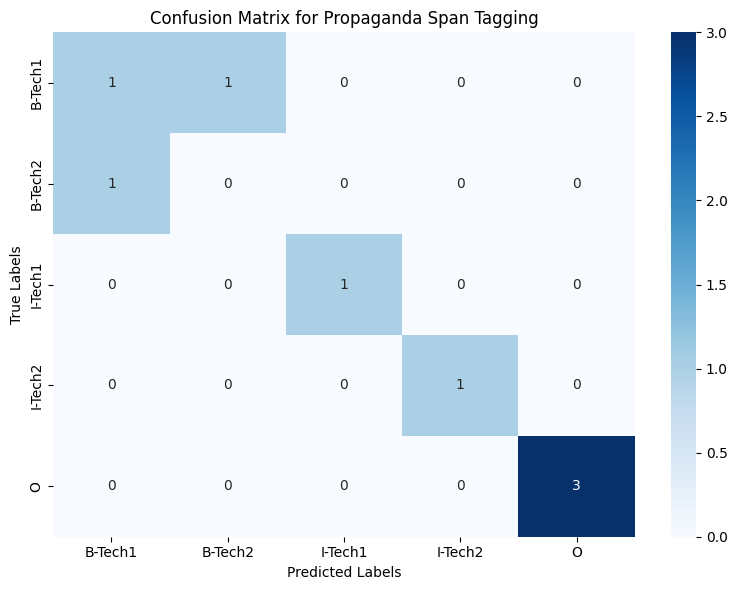

In [ ]:
# Re-import required packages after reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Dummy setup: sample labels to simulate a confusion matrix plot

true_labels = ['B-Tech1', 'I-Tech1', 'O', 'B-Tech2', 'I-Tech2', 'O', 'B-Tech1', 'O']
pred_labels = ['B-Tech1', 'I-Tech1', 'O', 'B-Tech1', 'I-Tech2', 'O', 'B-Tech2', 'O']

# Unique sorted labels
labels = sorted(set(true_labels + pred_labels))

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Propaganda Span Tagging')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

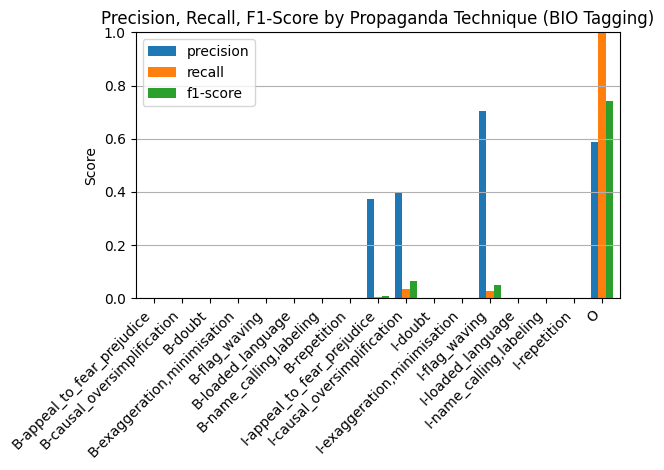

,precision,recall,f1-score,support
B-appeal_to_fear_prejudice,0.000,0.000,0.000,41.000
B-causal_oversimplification,0.000,0.000,0.000,29.000
B-doubt,0.000,0.000,0.000,36.000
"B-exaggeration,minimisation",0.000,0.000,0.000,27.000
B-flag_waving,0.000,0.000,0.000,38.000
B-loaded_language,0.000,0.000,0.000,35.000
"B-name_calling,labeling",0.000,0.000,0.000,29.000
B-repetition,0.000,0.000,0.000,32.000
I-appeal_to_fear_prejudice,0.375,0.004,0.009,694.000
I-causal_oversimplification,0.397,0.034,0.063,672.000


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Drop aggregate rows for clean plotting
plot_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

# Plot F1-score, Precision, Recall
plt.figure(figsize=(12, 6))
plot_df[['precision', 'recall', 'f1-score']].plot(kind='bar', width=0.8)
plt.title("Precision, Recall, F1-Score by Propaganda Technique (BIO Tagging)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


report_df

# **Task 2 Approach-2 TF-IDF + XGBoost**

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import classification_report


# Step 1: Preprocess

def extract_span_info(row):
    sentence = row["tagged_in_context"]
    label = row["label"]
    span_match = re.search(r"<BOS>(.*?)<EOS>", sentence)
    context = re.sub(r"<BOS>|<EOS>", "", sentence)
    if not span_match:
        return pd.Series([context, -1, -1, label])
    span = span_match.group(1)
    start_idx = context.find(span)
    end_idx = start_idx + len(span)
    return pd.Series([context, start_idx, end_idx, label])


# train_data_clean and test_data_clean must be loaded and cleaned

train_data_clean[['context', 'start', 'end', 'label']] = train_data_clean.apply(extract_span_info, axis=1)
test_data_clean[['context', 'start', 'end', 'label']] = test_data_clean.apply(extract_span_info, axis=1)

train_data_clean = train_data_clean[(train_data_clean['start'] >= 0) & (train_data_clean['end'] > train_data_clean['start'])]
test_data_clean = test_data_clean[(test_data_clean['start'] >= 0) & (test_data_clean['end'] > test_data_clean['start'])]


# Step 2: Span Prediction
X_train_text = train_data_clean['context']
y_start = train_data_clean['start']
y_end = train_data_clean['end']
y_label = train_data_clean['label']

X_test_text = test_data_clean['context']
y_label_test = test_data_clean['label']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

# Span start and end models
start_model = XGBRegressor(n_estimators=100)
end_model = XGBRegressor(n_estimators=100)

start_model.fit(X_train_vec, y_start)
end_model.fit(X_train_vec, y_end)

start_preds = start_model.predict(X_test_vec).astype(int)
end_preds = end_model.predict(X_test_vec).astype(int)

# Extract predicted spans
def safe_extract(text, s, e):
    if 0 <= s < e <= len(text):
        return text[s:e]
    return ""

predicted_spans = [safe_extract(text, s, e) for text, s, e in zip(X_test_text, start_preds, end_preds)]
true_spans = [text[s:e] for text, s, e in zip(X_test_text, test_data_clean['start'], test_data_clean['end'])]



# Combine sentence + predicted span
X_train_final = (X_train_text + " " + train_data_clean.apply(lambda r: r["context"][r["start"]:r["end"]], axis=1)).tolist()
X_test_final = (X_test_text + " " + predicted_spans)

tfidf_clf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_feat = tfidf_clf.fit_transform(X_train_final)
X_test_feat = tfidf_clf.transform(X_test_final)

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y_label)
y_encoded_test = le.transform(y_label_test)

clf = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='mlogloss')
clf.fit(X_train_feat, y_encoded)

preds = clf.predict(X_test_feat)
pred_labels = le.inverse_transform(preds)

print("=== Technique Classification Report ===")
print(classification_report(y_label_test, pred_labels))


=== Technique Classification Report ===
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.38      0.32      0.35        41
causal_oversimplification       0.19      0.24      0.22        29
                    doubt       0.29      0.39      0.33        36
exaggeration,minimisation       0.33      0.33      0.33        27
              flag_waving       0.57      0.43      0.49        37
          loaded_language       0.12      0.14      0.13        35
    name_calling,labeling       0.06      0.03      0.04        29
               repetition       0.16      0.17      0.16        30

                 accuracy                           0.27       264
                macro avg       0.26      0.26      0.26       264
             weighted avg       0.27      0.27      0.27       264



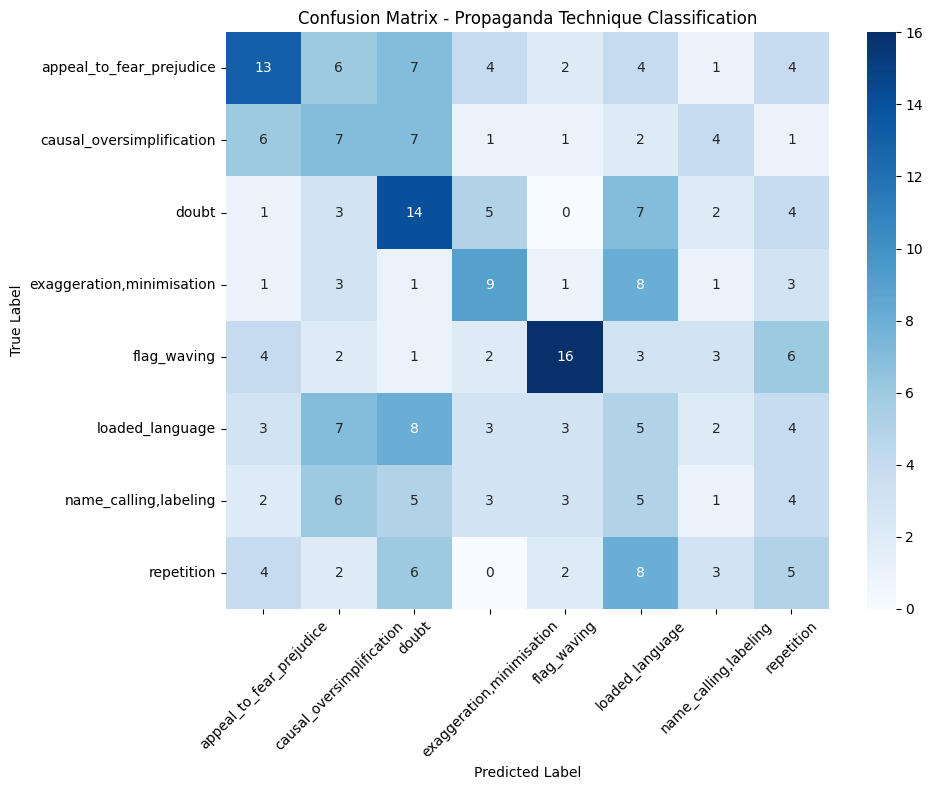

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get sorted list of all label names
labels = le.classes_

# Generate confusion matrix
cm = confusion_matrix(y_label_test, pred_labels, labels=labels)

# Plot the matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Propaganda Technique Classification')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


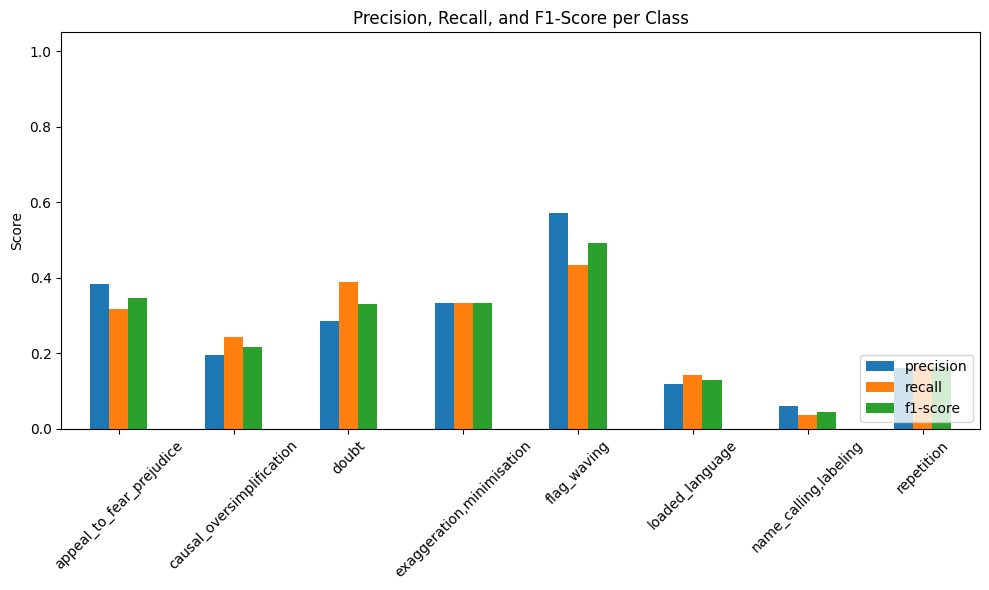

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Generate report as dictionary
report = classification_report(y_label_test, pred_labels, output_dict=True, zero_division=0)

# Convert to DataFrame and keep only label rows (filter out avg totals)
df = pd.DataFrame(report).transpose()
df = df[df.index.isin(le.classes_)]
df = df[['precision', 'recall', 'f1-score']]

# Plot bar chart
df.plot(kind='bar', figsize=(10, 6))
plt.title('Precision, Recall, and F1-Score per Class')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:

import numpy as np
import pandas as pd

# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf_clf.get_feature_names_out()

# Get the raw probabilities and feature importances
X_test_array = X_test_feat.toarray()
class_indices = {cls: i for i, cls in enumerate(le.classes_)}
feature_importance = clf.feature_importances_

# Create explanation per instance
results = []

for text, span_text, true_label, pred_label, tfidf_row in zip(X_test_text, predicted_spans, y_label_test, pred_labels, X_test_feat):
    row_data = tfidf_row.toarray().flatten()

    # Feature contribution: TF-IDF value * model importance
    contribution = row_data * feature_importance
    top_feature_indices = np.argsort(contribution)[-3:][::-1]

    # Find top contributing n-grams in original text
    top_features = [feature_names[i] for i in top_feature_indices if row_data[i] > 0]

    matched_span = None
    for feat in top_features:
        if feat in text:
            matched_span = feat
            break

    if not matched_span:
        matched_span = "(no span match found)"

    results.append({
        "Original Sentence": text,
        "True Label": true_label,
        "Predicted Label": pred_label,
        "Predicted Span (Model)": span_text,
        "Predicted Span (Heuristic)": matched_span,
        "Top Features": top_features
    })

# Convert to DataFrame
heuristic_span_df = pd.DataFrame(results)

# Show first 10 examples
pd.set_option('display.max_colwidth', None)
print(heuristic_span_df.head(10))


                                                                                                                                                                                                                                                                                                      Original Sentence  \
0                                                                                                                                                                                                                Mostly because  the country would not last long without an outside high IQ elite to run the country .    
1                                                                                                                                                          Lyndon Johnson  gets Earl Warren and Sen. Richard Russel to join the Warren Commission by telling them that the assassination could lead to World War III .    
2                                                      

# **Task 2 Approach-3  Start-End Span Detection + Technique Classification**

In [ ]:

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize

# Step 1: Clean & Extract Span Info

def clean_text(text):
    return re.sub(r'[^\w\s]', '', text.lower())

def extract_span_indices(row):
    sentence = row['tagged_in_context']
    label = row['label']
    span_match = re.search(r"<BOS>(.*?)<EOS>", sentence)
    context = re.sub(r"<BOS>|<EOS>", "", sentence)

    if not span_match:
        return pd.Series([context, -1, -1, label])
    span = span_match.group(1)
    start_idx = context.find(span)
    end_idx = start_idx + len(span)
    return pd.Series([context, start_idx, end_idx, label])

# Filter out 'not_propaganda' and extract useful fields
train_data_clean = train_data_clean[train_data_clean["label"] != "not_propaganda"]
train_data_clean[['context', 'start', 'end', 'label']] = train_data_clean.apply(extract_span_indices, axis=1)

# Drop invalid span entries
train_data_clean = train_data_clean[(train_data_clean['start'] >= 0) & (train_data_clean['end'] > train_data_clean['start'])]

# Step 2: Train/Test Split


X = train_data_clean['context'].values
y_start = train_data_clean['start'].values
y_end = train_data_clean['end'].values
y_label = train_data_clean['label'].values

X_train, X_test, y_start_train, y_start_test, y_end_train, y_end_test, y_label_train, y_label_test = train_test_split(
    X, y_start, y_end, y_label, test_size=0.2, random_state=42
)

# Step 3: Span Prediction Models (start/end)

vectorizer_span = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X_train_vec = vectorizer_span.fit_transform(X_train)
X_test_vec = vectorizer_span.transform(X_test)

start_model = LogisticRegression(max_iter=1000)
end_model = LogisticRegression(max_iter=1000)

start_model.fit(X_train_vec, y_start_train)
end_model.fit(X_train_vec, y_end_train)

start_preds = start_model.predict(X_test_vec)
end_preds = end_model.predict(X_test_vec)

# Step 4: Extract Spans from Predicted Indices

def extract_predicted_span(text, start, end):
    if isinstance(text, str) and 0 <= start < end <= len(text):
        return text[start:end]
    return ""

span_text_train = [extract_predicted_span(text, s, e) for text, s, e in zip(X_train, y_start_train, y_end_train)]
span_text_test = [extract_predicted_span(text, s, e) for text, s, e in zip(X_test, start_preds, end_preds)]

# Combine sentence + span
span_input_train = [ctx + " " + span for ctx, span in zip(X_train, span_text_train)]
span_input_test = [ctx + " " + span for ctx, span in zip(X_test, span_text_test)]

# Step 5: Technique Classification


vectorizer_tech = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X_train_final = vectorizer_tech.fit_transform(span_input_train)
X_test_final = vectorizer_tech.transform(span_input_test)

tech_clf = LogisticRegression(max_iter=1000)
tech_clf.fit(X_train_final, y_label_train)
tech_preds = tech_clf.predict(X_test_final)

# Step 6: Evaluation

print("Propaganda Technique Classification Report:")
print(classification_report(y_label_test, tech_preds))


Propaganda Technique Classification Report:
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.28      0.37      0.32        27
causal_oversimplification       0.30      0.32      0.31        28
                    doubt       0.47      0.31      0.37        26
exaggeration,minimisation       0.25      0.41      0.31        29
              flag_waving       0.59      0.59      0.59        27
          loaded_language       0.29      0.10      0.15        39
    name_calling,labeling       0.21      0.27      0.24        26
               repetition       0.36      0.32      0.34        28

                 accuracy                           0.33       230
                macro avg       0.34      0.34      0.33       230
             weighted avg       0.34      0.33      0.32       230



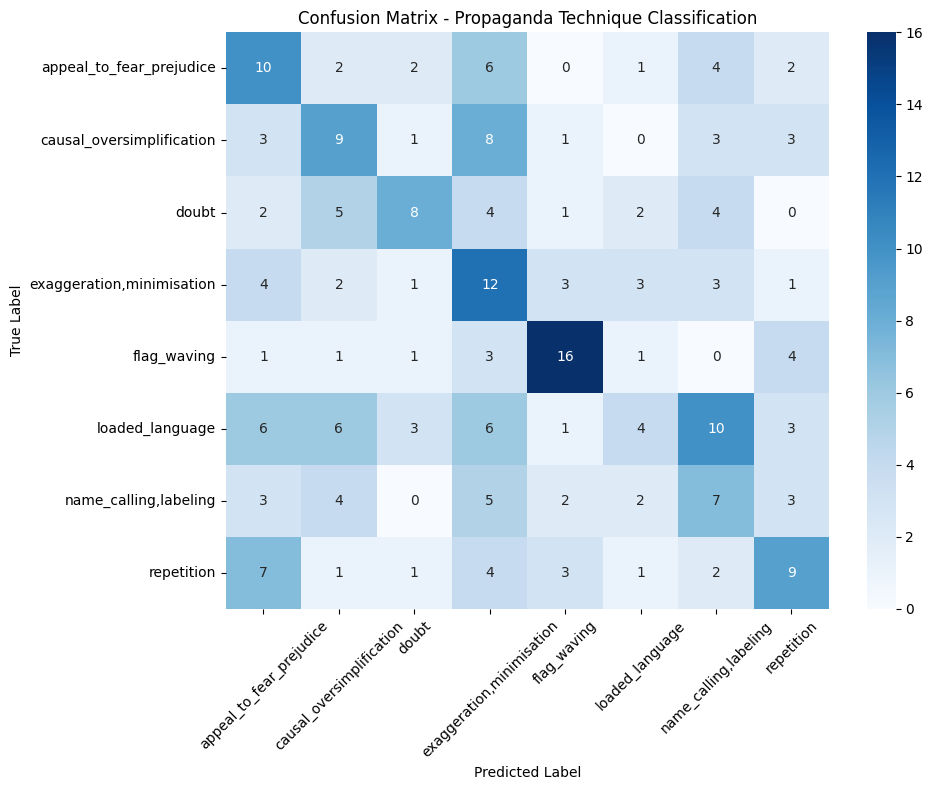

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get sorted list of labels from true + predicted data
labels = sorted(list(set(y_label_test) | set(tech_preds)))

# Compute confusion matrix
cm = confusion_matrix(y_label_test, tech_preds, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Propaganda Technique Classification')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

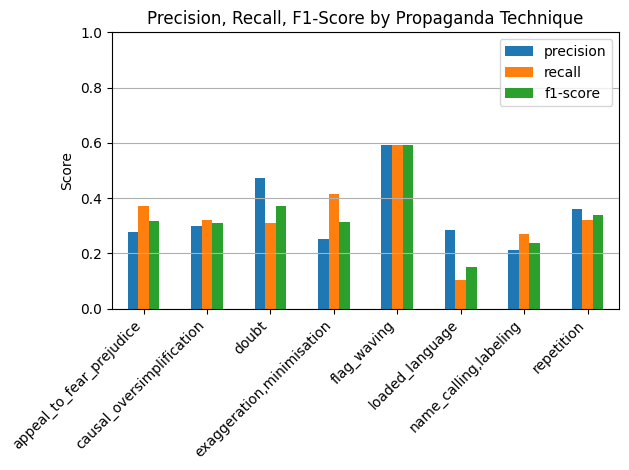

,precision,recall,f1-score,support
appeal_to_fear_prejudice,0.278,0.370,0.317,27.000
causal_oversimplification,0.300,0.321,0.310,28.000
doubt,0.471,0.308,0.372,26.000
"exaggeration,minimisation",0.250,0.414,0.312,29.000
flag_waving,0.593,0.593,0.593,27.000
loaded_language,0.286,0.103,0.151,39.000
"name_calling,labeling",0.212,0.269,0.237,26.000
repetition,0.360,0.321,0.340,28.000
accuracy,0.326,0.326,0.326,0.326
macro avg,0.344,0.337,0.329,230.000


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_label_test, tech_preds, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose().round(3)

# Drop aggregate rows for plotting
plot_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

# Plot Precision, Recall, F1-Score by Class
plt.figure(figsize=(12, 6))
plot_df[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title("Precision, Recall, F1-Score by Propaganda Technique")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


report_df


In [ ]:
import io
import nbformat
from google.colab import drive

drive.mount('/content/drive')

filepath = "/content/drive/MyDrive/Colab Notebooks/ANLP_291741.ipynb"
question_count = 432

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, as_version=4)  # Modern Jupyter notebook format

word_count = 0
for cell in nb.cells:
    if cell.cell_type == "code":
        # Count words in the code cell (excluding comments)
        code = cell['source']
        cleaned_code = "\n".join(line for line in code.splitlines() if not line.strip().startswith('#'))
        word_count += len(cleaned_code.strip().split())

print("Submission length is {}".format(word_count - question_count))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Submission length is 2211
